<a href="https://colab.research.google.com/github/zwimpee/cursivetransformer/blob/main/cursivetransformer_mech_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import os
DEVELOPMENT_MODE = False
# Detect if we're running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

# Install if in Colab
if IN_COLAB:
    %pip install transformer_lens
    %pip install circuitsvis
    # Install a faster Node version
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs  # noqa

# Hot reload in development mode & not running on the CD
if not IN_COLAB:
    from IPython import get_ipython
    ip = get_ipython()
    if not ip.extension_manager.loaded:
        ip.extension_manager.load('autoreload')
        %autoreload 2

IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"

Running as a Colab notebook
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.0/311.0 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [2]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [3]:
!pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python
!pip install transformer_lens
!pip install gradio
!pip install wandb
!pip install einops
!pip install matplotlib
!pip install datasets

# Clone the cursivetransformer repository and install its requirements
!rm -rf cursivetransformer && git clone https://github.com/zwimpee/cursivetransformer.git
!pip install -r cursivetransformer/requirements.txt

# Login to Weights & Biases (replace 'your_api_key' with your actual API key)
import wandb
wandb.login()

  Cloning https://github.com/callummcdougall/CircuitsVis.git to /tmp/pip-req-build-vu7kk_g_
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/CircuitsVis.git /tmp/pip-req-build-vu7kk_g_
  Resolved https://github.com/callummcdougall/CircuitsVis.git to commit 1e6129d08cae7af9242d9ab5d3ed322dd44b4dd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for circuitsvis: filename=circuitsvis-0.0.0-py3-none-any.whl size=6172334 sha256=59415c32edc93016c6c42f3b4833706a3be43b700e7573be5495cc7c0ec5f306
  Stored in directory: /tmp/pip-ephem-wheel-cache-f8vobm8x/wheels/86/be/ad/78078aba9344d200aad61b63d35cdaecdec160212f039eed74
Successfully built circuitsvis
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib_metadata 8.4.0
    Uninstalling importlib_metadata-8.4.0:
      Successfully uninstalled importlib_metadata-8.4.0
  Attem

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import sys
sys.path.append('/content/cursivetransformer')  # Adjust the path if necessary

import sys
import os
import copy
import types

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from jaxtyping import Float, Int

import einops
import matplotlib.pyplot as plt
import seaborn as sns
# import circuitsvis as cv
from IPython.display import display

from typing import Callable, Dict, Optional, Union

from cursivetransformer.model import (
    get_all_args,
    get_checkpoint,
    get_latest_checkpoint_artifact
)
from cursivetransformer.data import (
    create_datasets,
    offsets_to_strokes
)
from cursivetransformer.sample import (
    generate,
    generate_n_words,
    plot_strokes
)
from cursivetransformer.mech_interp import (
    HookedCursiveTransformer,
    HookedCursiveTransformerConfig,
    convert_cursivetransformer_model_config,
    visualize_attention
)

In [5]:
args = get_all_args(False)
args.sample_only = True
args.load_from_run_id = '6le6tujz'  # Replace with your actual run ID
args.wandb_entity = 'sam-greydanus'
args.dataset_name = 'bigbank'  # Replace with your dataset name
args.wandb_run_name = 'cursivetransformer_dictionary_learning'

torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

train_dataset, test_dataset = create_datasets(args)

args.block_size = train_dataset.get_stroke_seq_length()
args.context_block_size = train_dataset.get_text_seq_length()
args.vocab_size = train_dataset.get_vocab_size()
args.context_vocab_size = train_dataset.get_char_vocab_size()

Trying to load dataset file from /content/cursivetransformer/data/bigbank.json.zip
Succeeded in loading the bigbank dataset; contains 1900 items.
For a dataset of 1805 examples we can generate 440811596555 combinations of 4 examples.
Generating 497000 4-word examples.
For a dataset of 95 examples we can generate 3183545 combinations of 4 examples.
Generating 3000 4-word examples.
Number of examples in the train dataset: 497000
Number of examples in the test dataset: 3000
Max token sequence length: 1000
Number of unique characters in the ascii vocabulary: 71
Ascii vocabulary:
	" enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"'(BCQLMWYU,ZF!DXV?KPGJ"
Split up the dataset into 497000 training examples and 3000 test examples


In [6]:
cfg = convert_cursivetransformer_model_config(args)
model = HookedCursiveTransformer.from_pretrained("cursivetransformer", cfg)

Loading pretrained model cursivetransformer
Finding latest checkpoint for W&B run id 6le6tujz
  model:best_checkpoint:v70
  model:best_checkpoint:v71
  model:best_checkpoint:v72
  model:best_checkpoint:v73
  model:best_checkpoint:v74
  model:best_checkpoint:v75
  model:best_checkpoint:v76
  model:best_checkpoint:v77
  model:best_checkpoint:v78
  model:best_checkpoint:v79
  model:best_checkpoint:v80
  model:best_checkpoint:v81
  model:best_checkpoint:v82
  model:best_checkpoint:v83
  model:best_checkpoint:v84
  model:best_checkpoint:v85
  model:best_checkpoint:v86
  model:best_checkpoint:v87
  model:best_checkpoint:v88
  model:best_checkpoint:v89
  wandb-history:run-6le6tujz-history:v4
Selected:  model:best_checkpoint:v89


wandb:   1 of 1 files downloaded.  


Successfully loaded pretrained model cursivetransformer


In [7]:
# Add batch dimension to your inputs
x, c, y = test_dataset[0]
x = x.unsqueeze(0) # Shape: [1, 1000]
c = c.unsqueeze(0) # Shape: [1, 50]
y = y.unsqueeze(0) # Shape: [1, 1000]

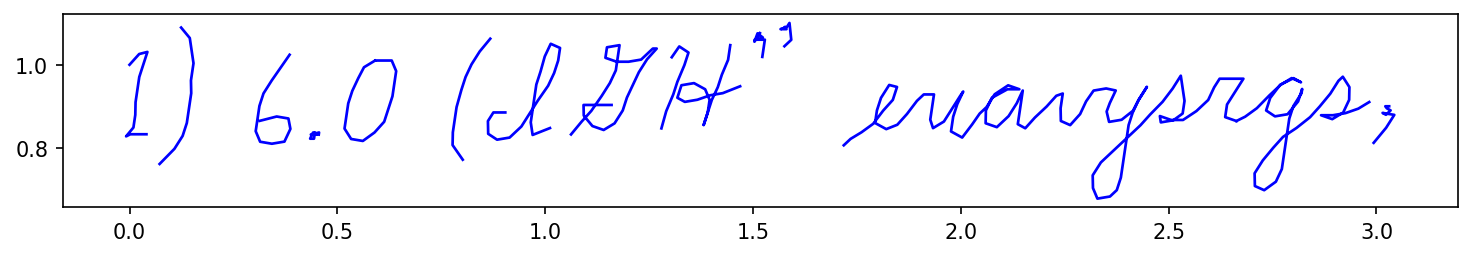

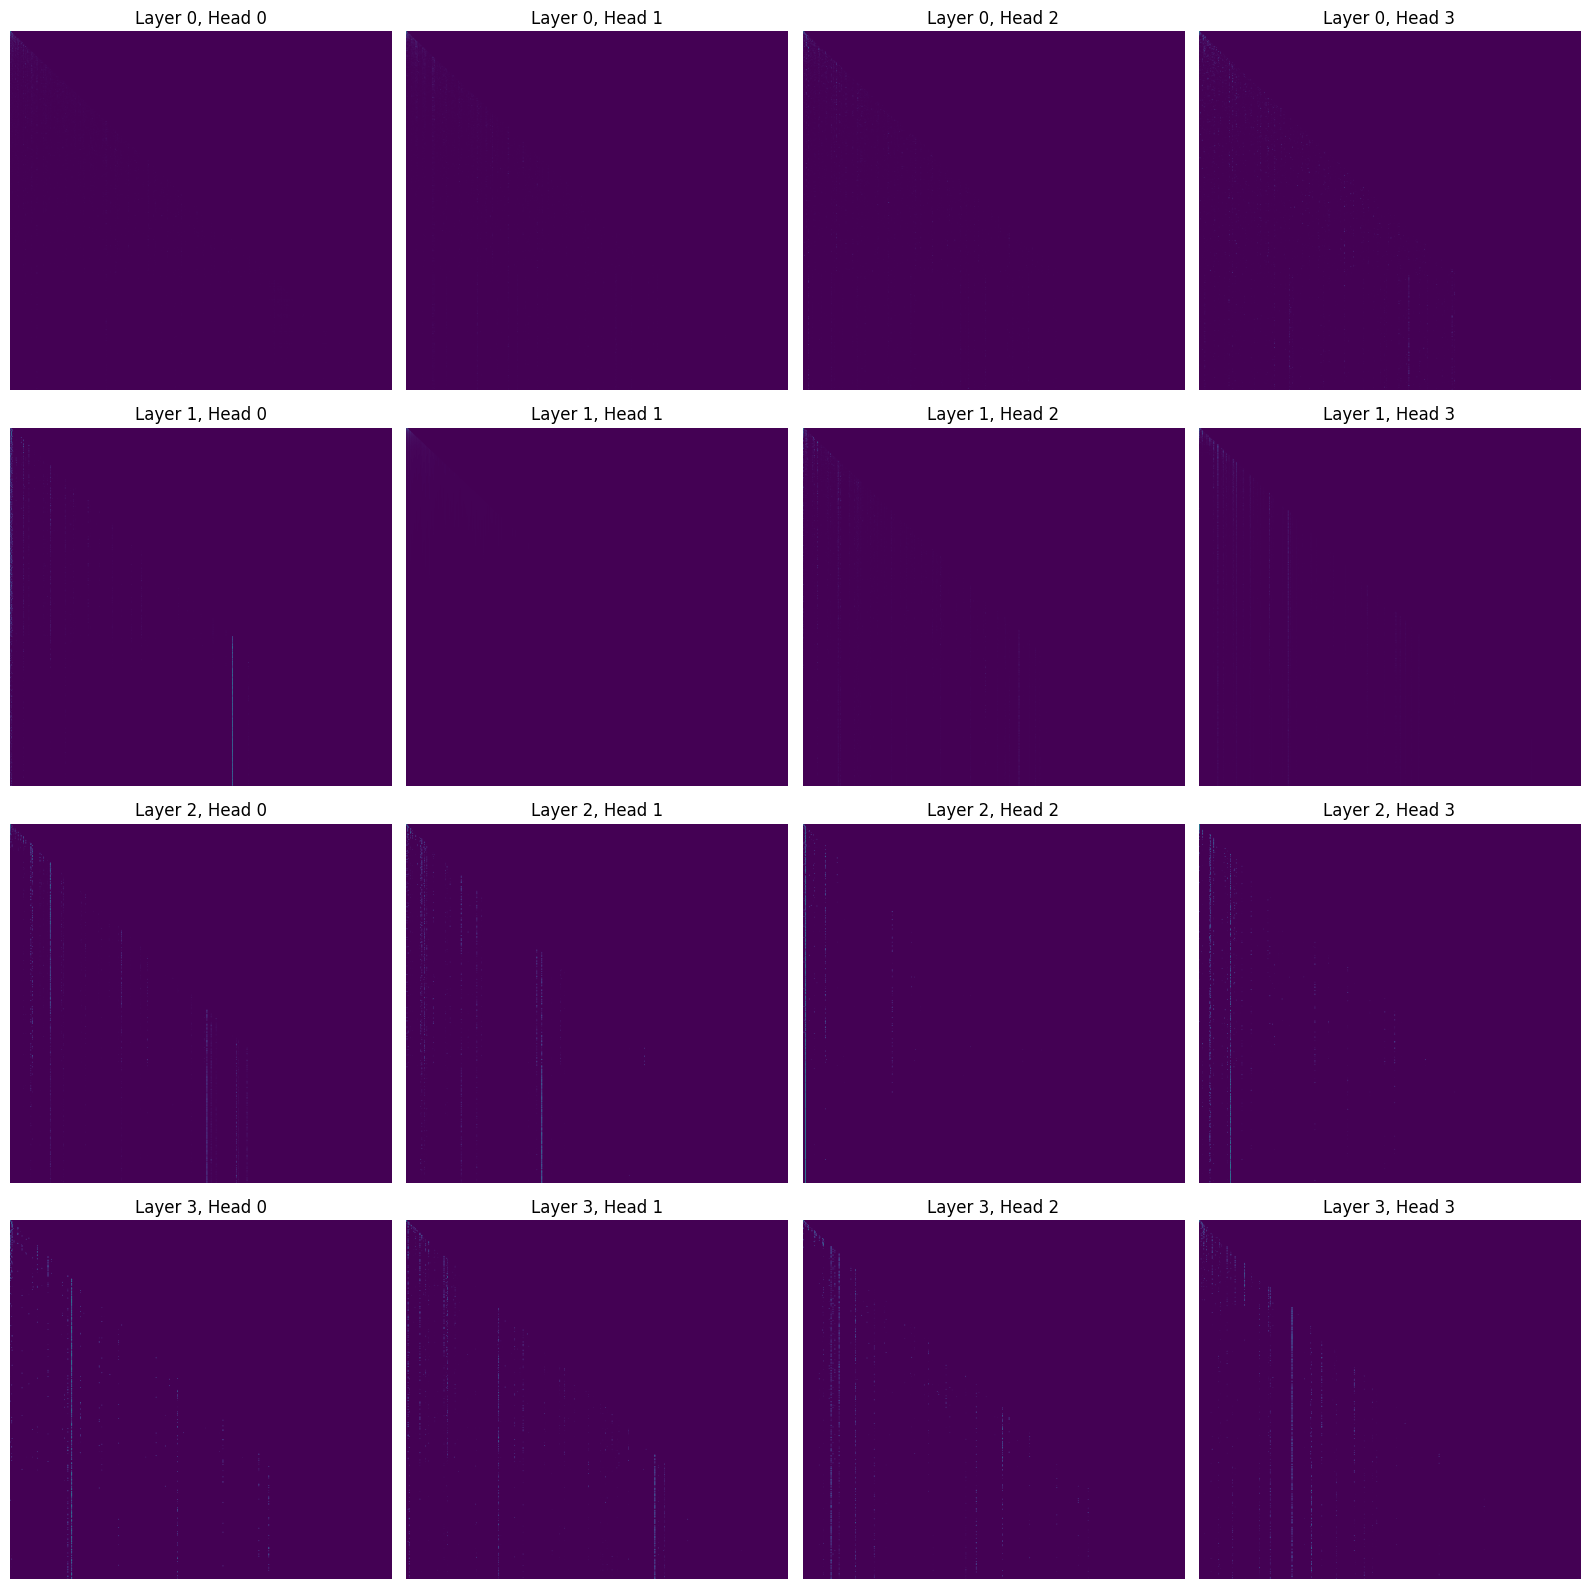

In [8]:
_ = plot_strokes(offsets_to_strokes(test_dataset.decode_stroke(x)),"")
_ = visualize_attention(model, x, c, layer_range=range(4), head_range=range(4), attn_type='self')

# Scratch

Visualizing samples from the test dataset:
Sample 1: 1) 6.0 (IGH" euavysrgs,


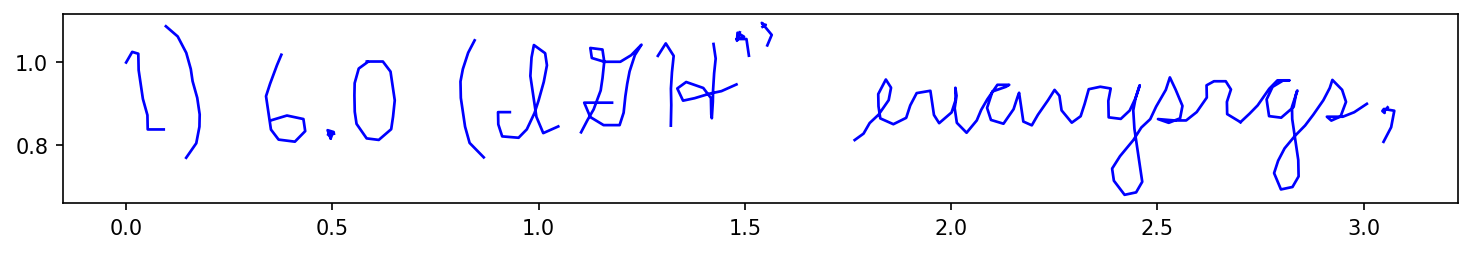

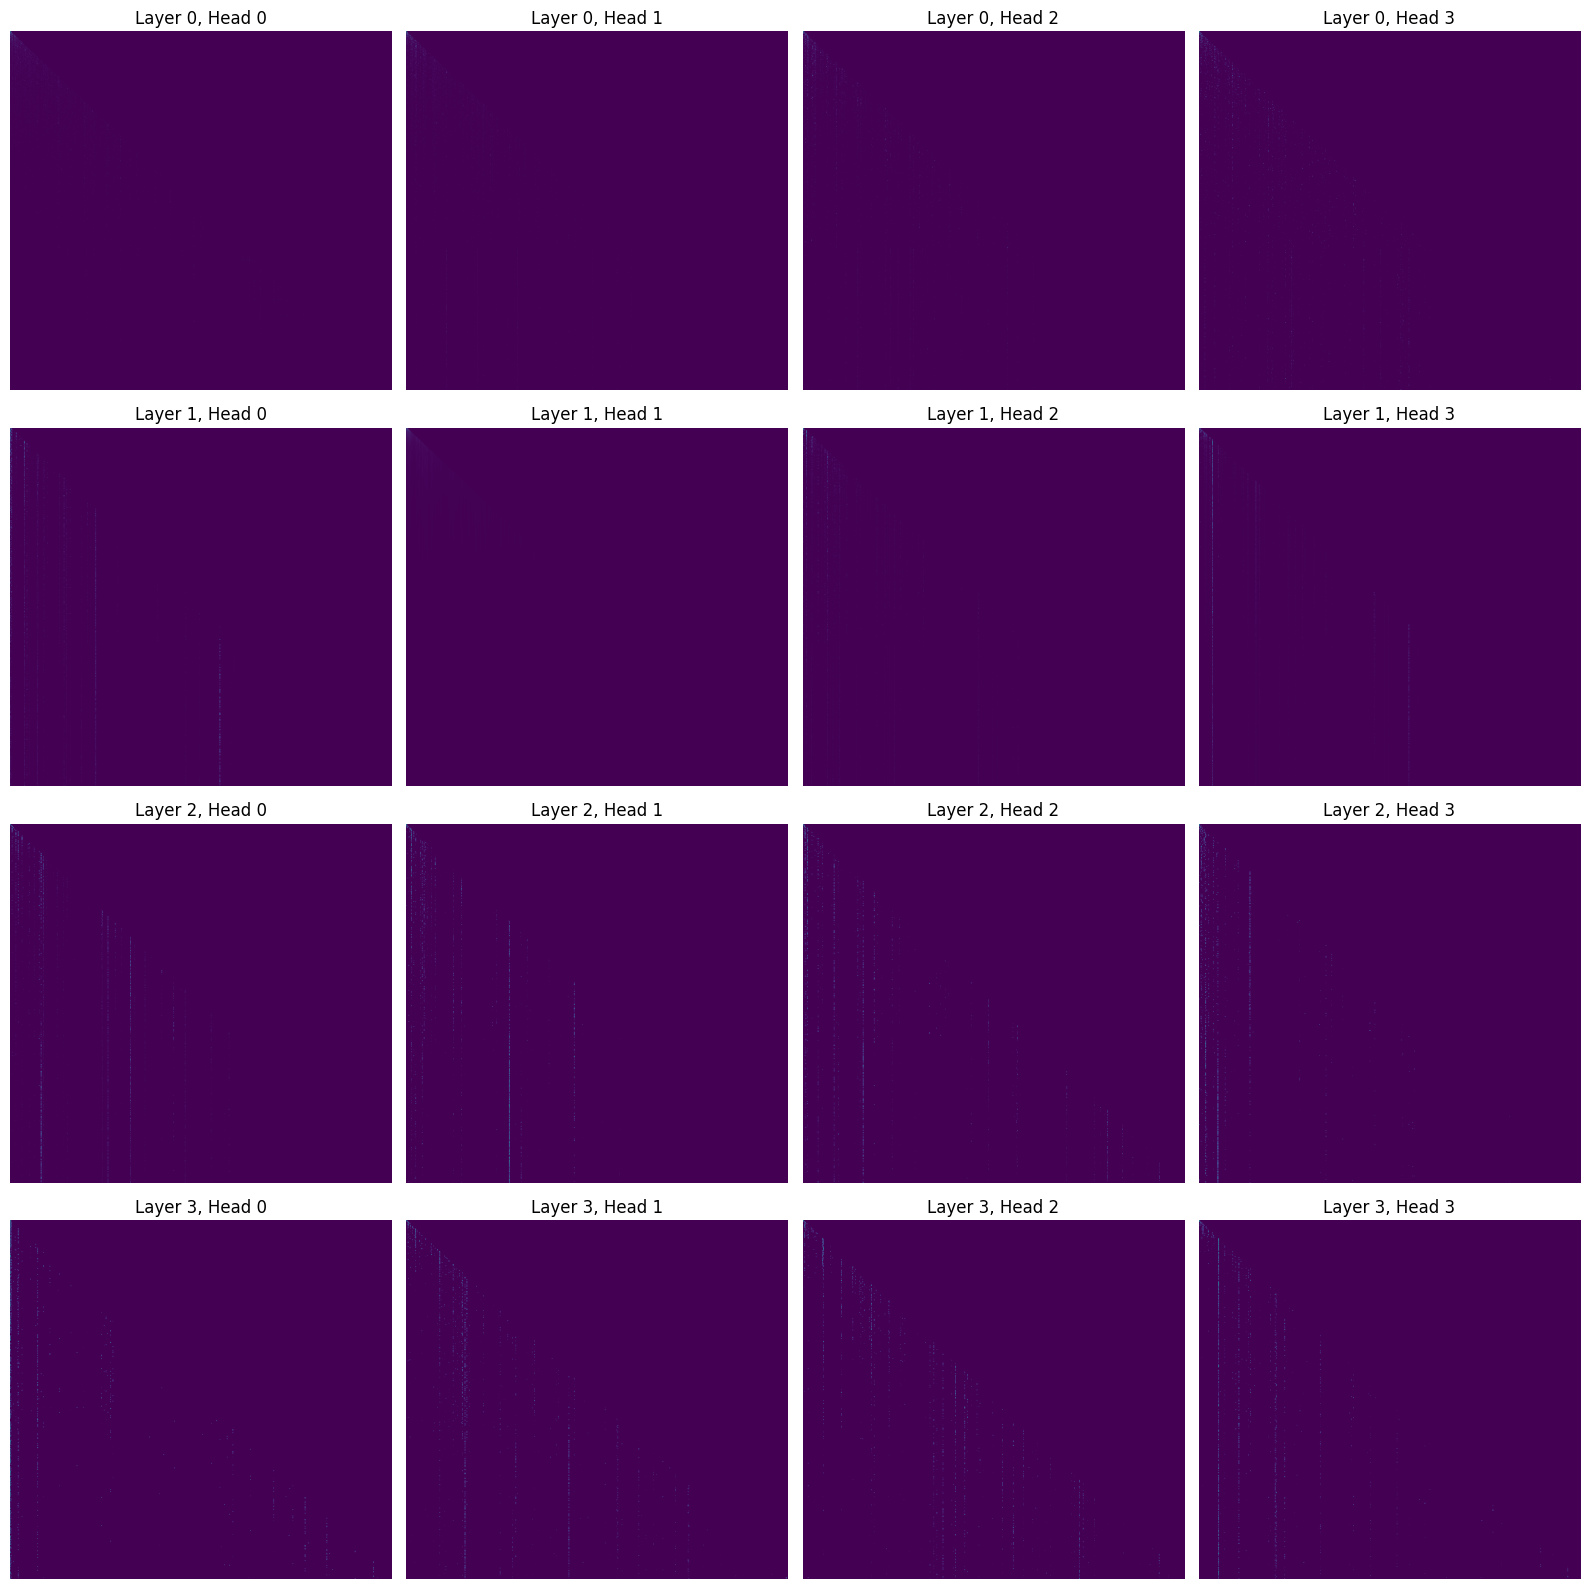



Sample 2: 13326! Fnbdxpng cecxcupk 4


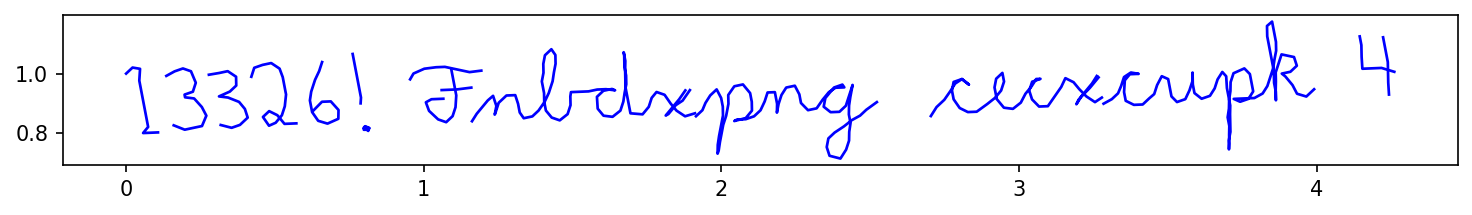

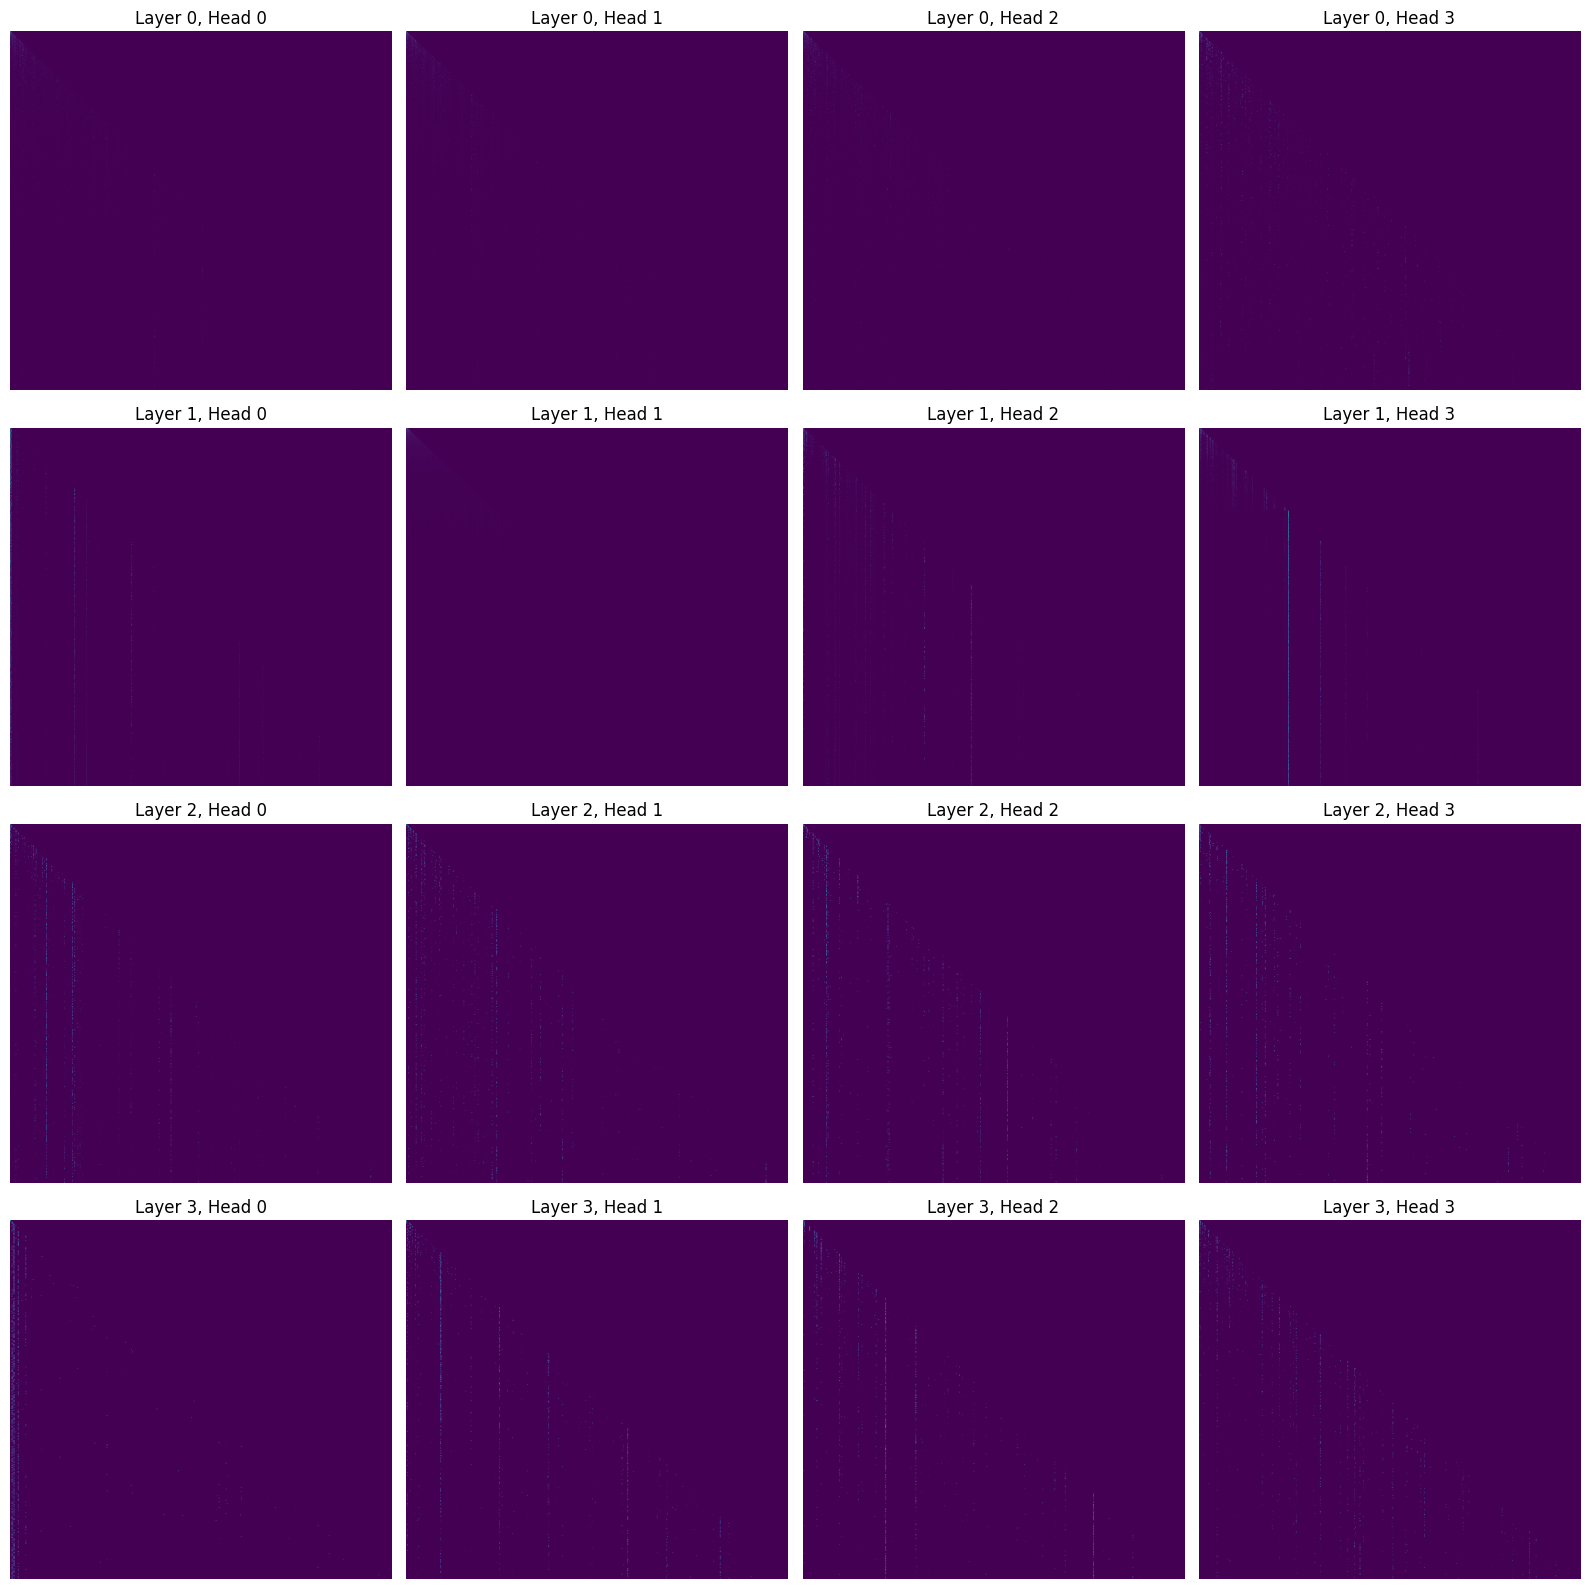



Sample 3: vw'stfws. mveyvc? (IGH" ardd


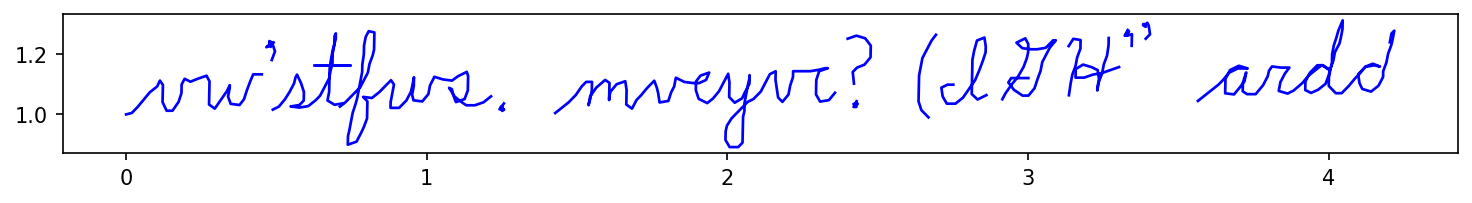

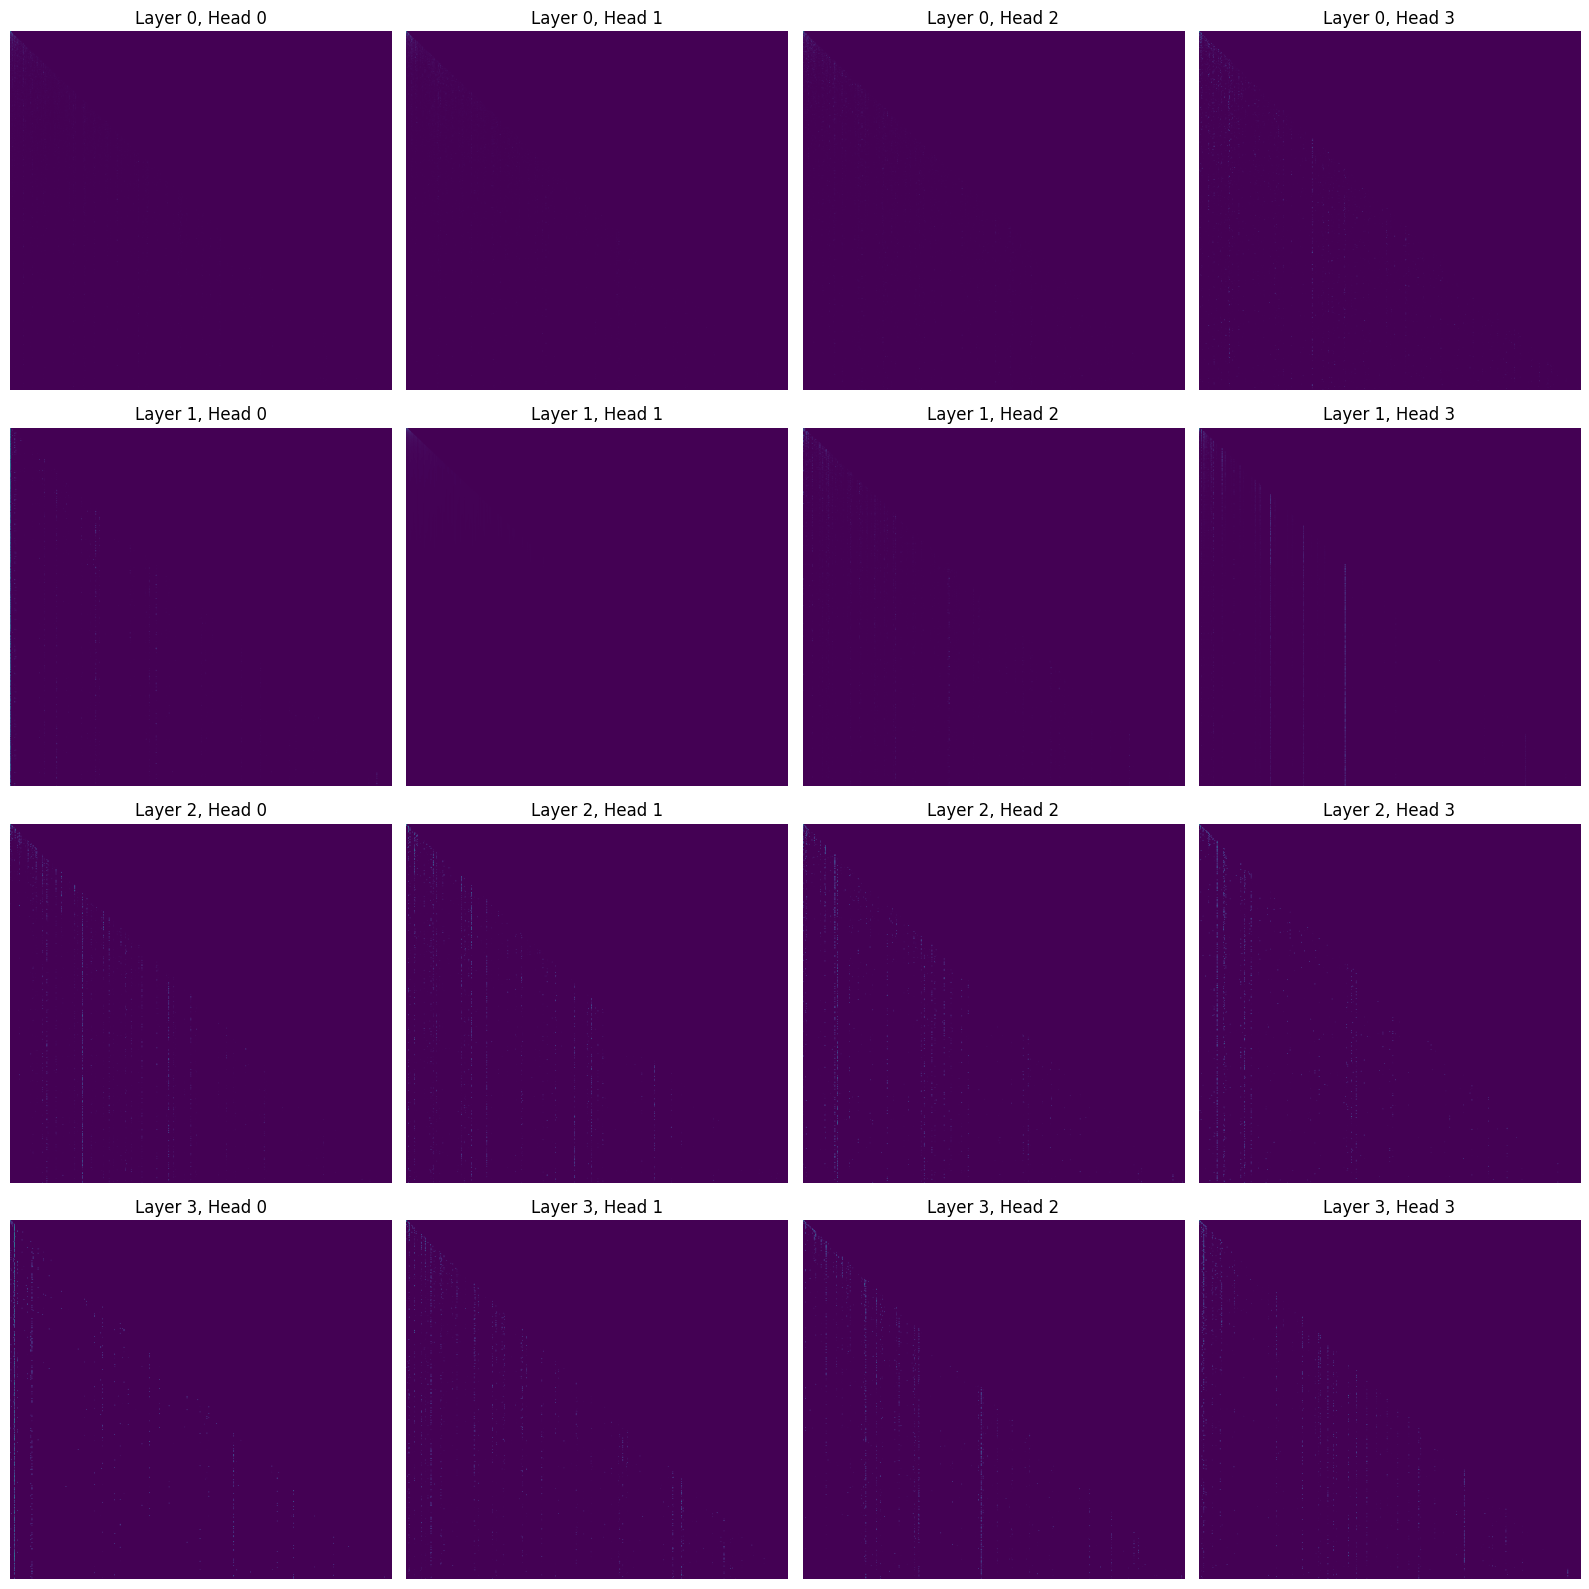



Sample 4: Eunmt afsc 07. euavysrgs,


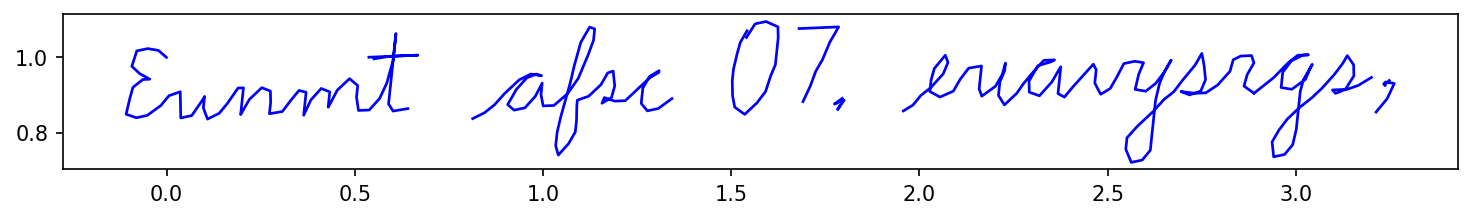

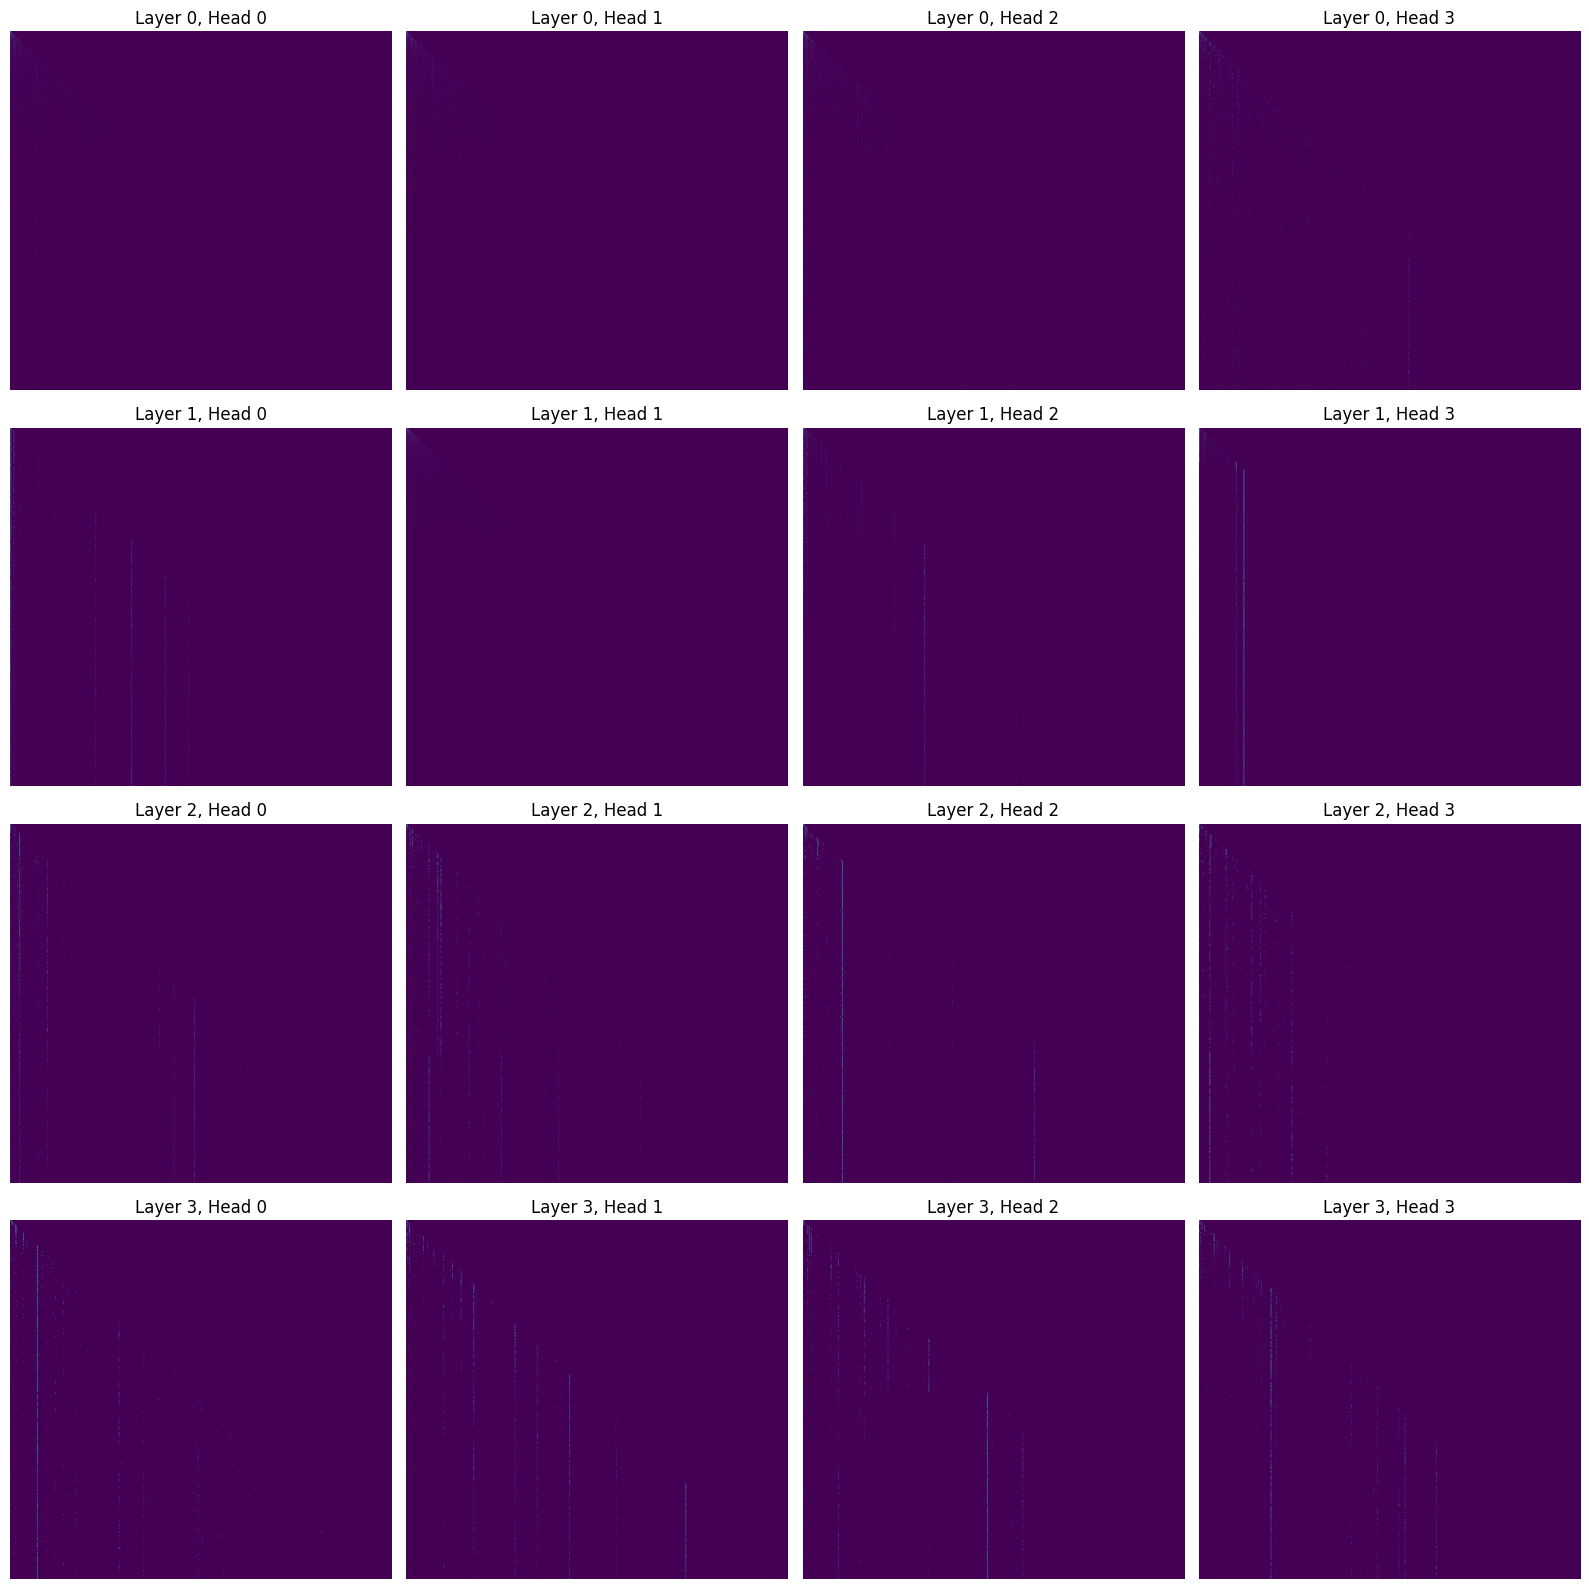



Sample 5: cecxcupk Nkerr syghyxn. Dmdmfjwifw.


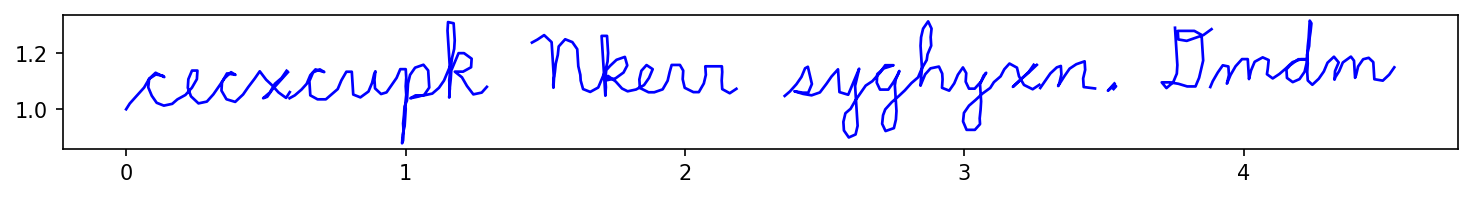

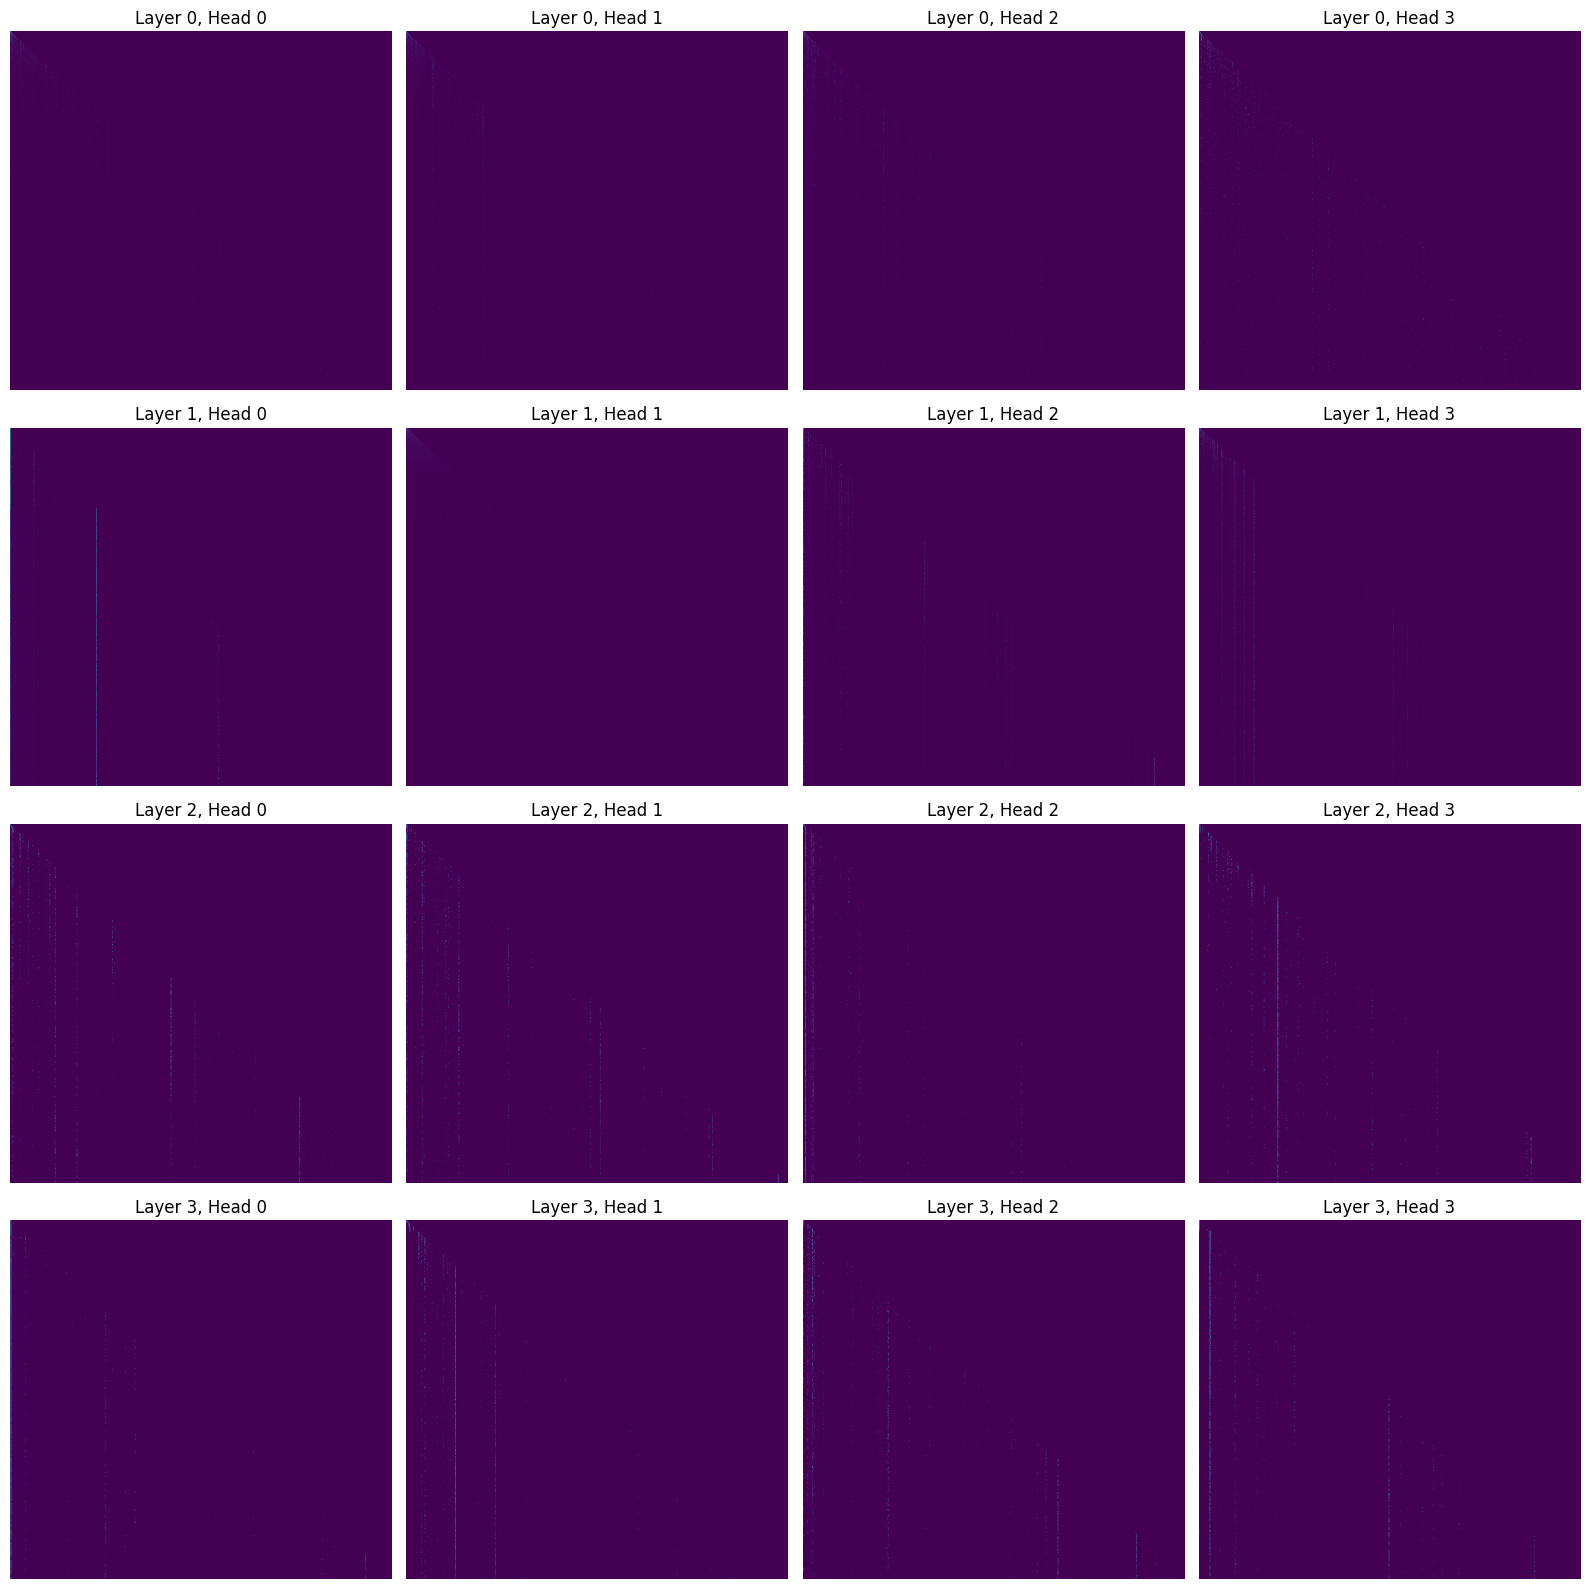

In [9]:
def visualize_samples(dataset, num_samples=5):
    for i in range(num_samples):
        x, c, y = dataset[i]
        text = dataset.decode_text(c)
        print(f"Sample {i+1}: {text}")
        strokes = offsets_to_strokes(dataset.decode_stroke(x))
        _ = plot_strokes(strokes, "")
        _ = visualize_attention(model, x.unsqueeze(0), c.unsqueeze(0), layer_range=range(4), head_range=range(4), attn_type='self')
        print("\n")

print("Visualizing samples from the test dataset:")
visualize_samples(test_dataset)

Attention patterns for loop character 'o':
Sample 6: Tlfopth Fnbdxpng uzoe ohsbqvj,


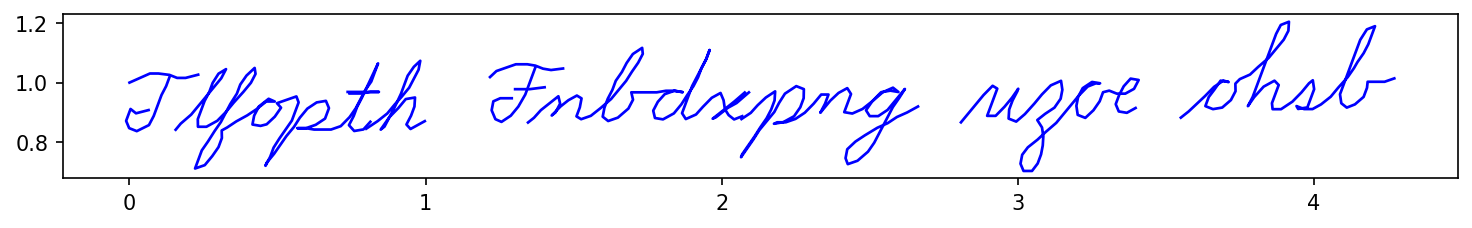

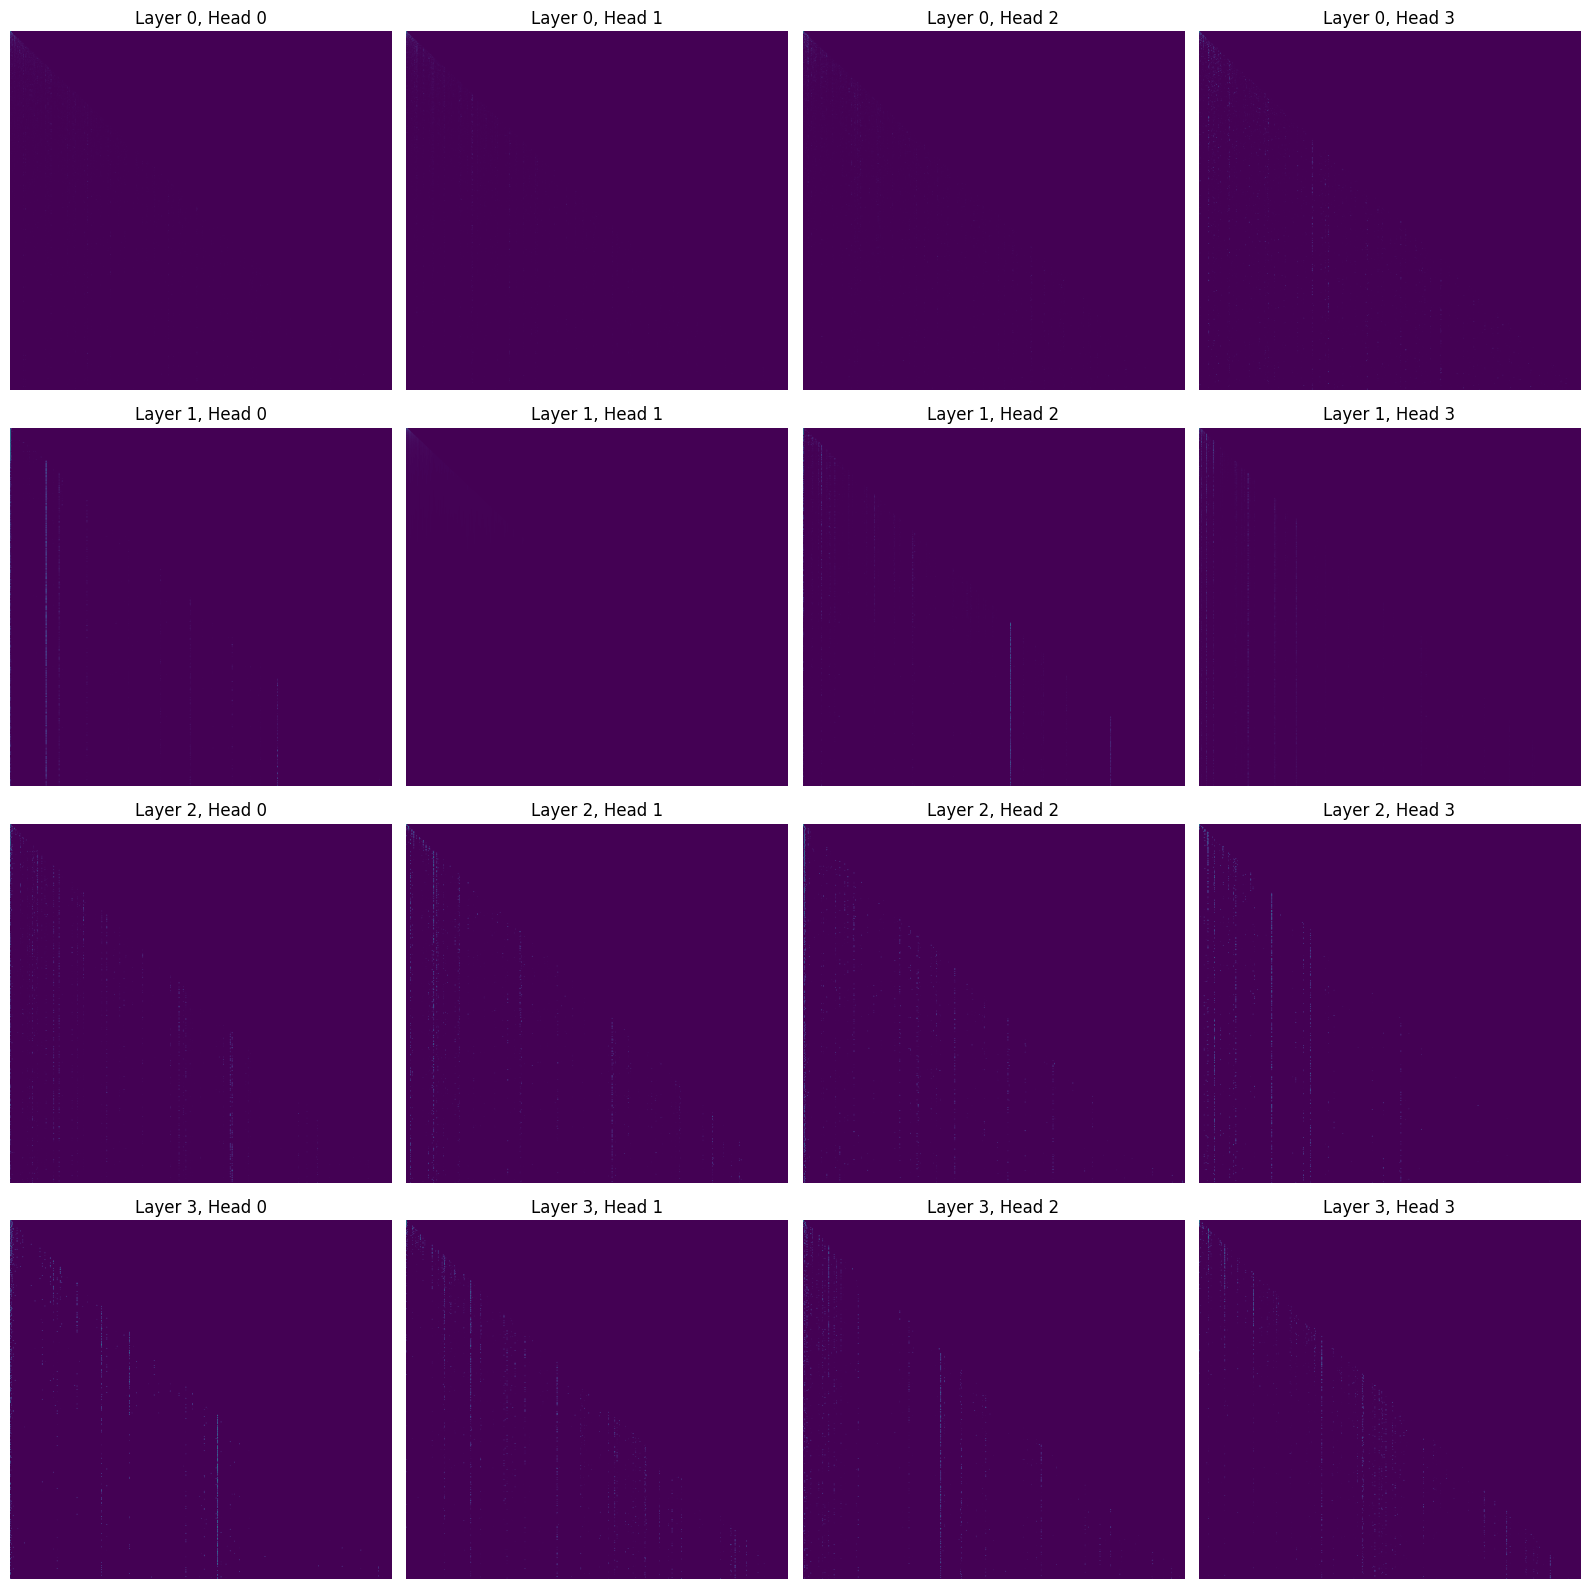



Sample 10: ohsbqvj, xuwh euavysrgs, Ype


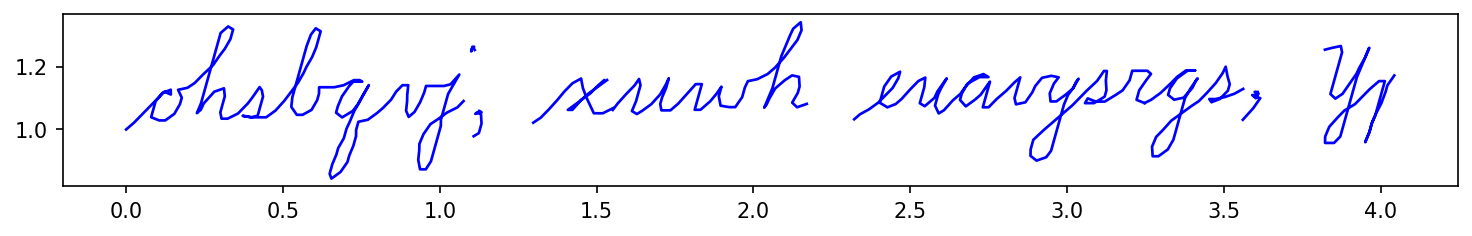

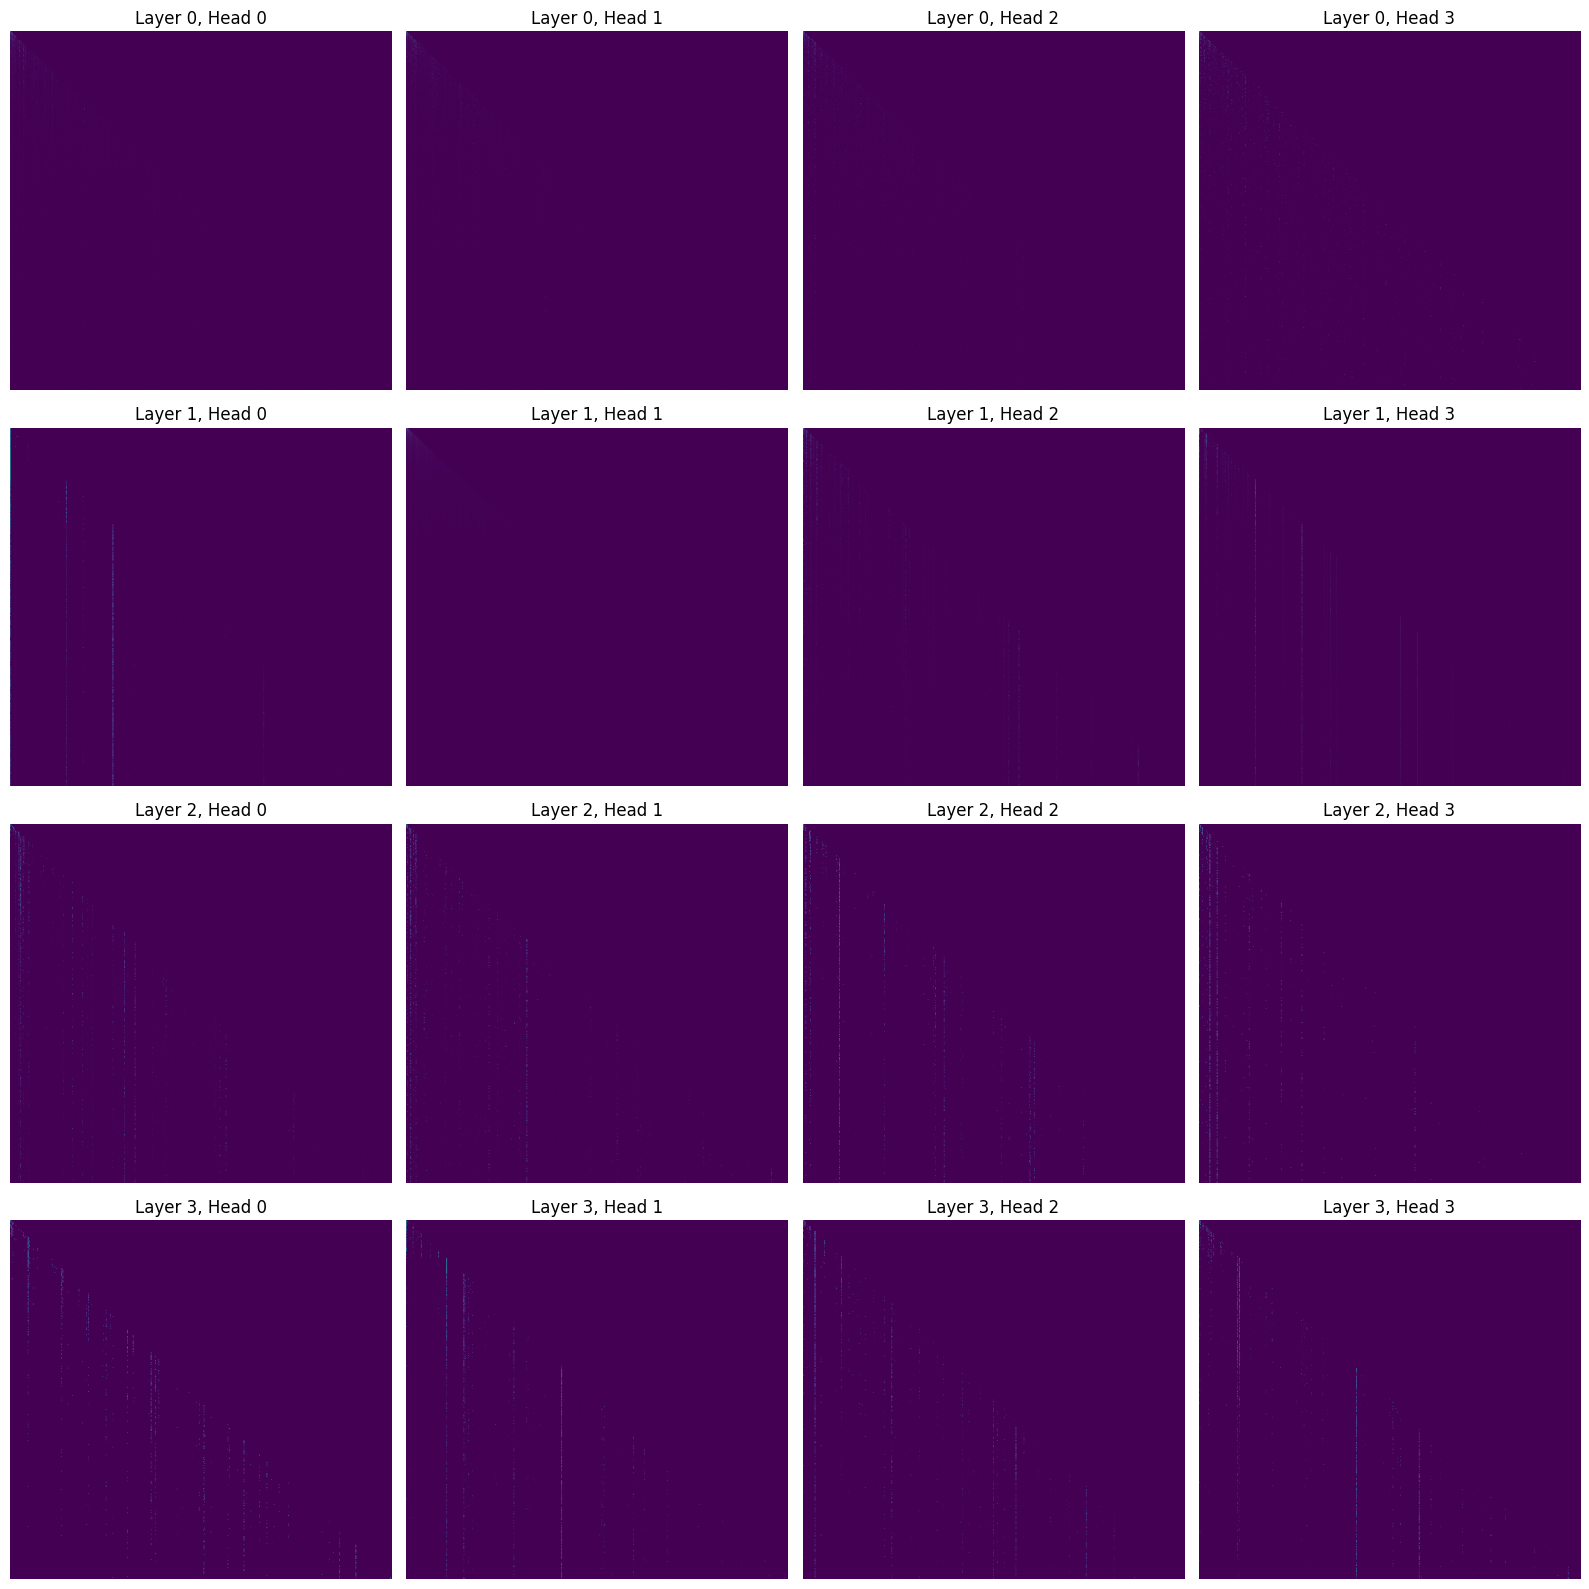



Sample 12: Fnbdxpng vw'stfws. (wesoz EAEI,


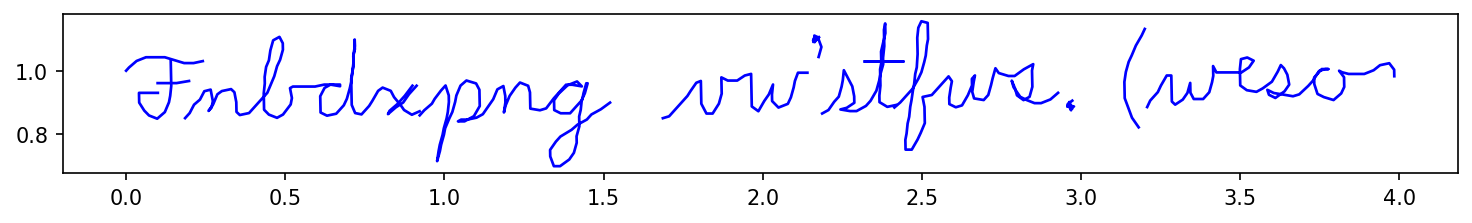

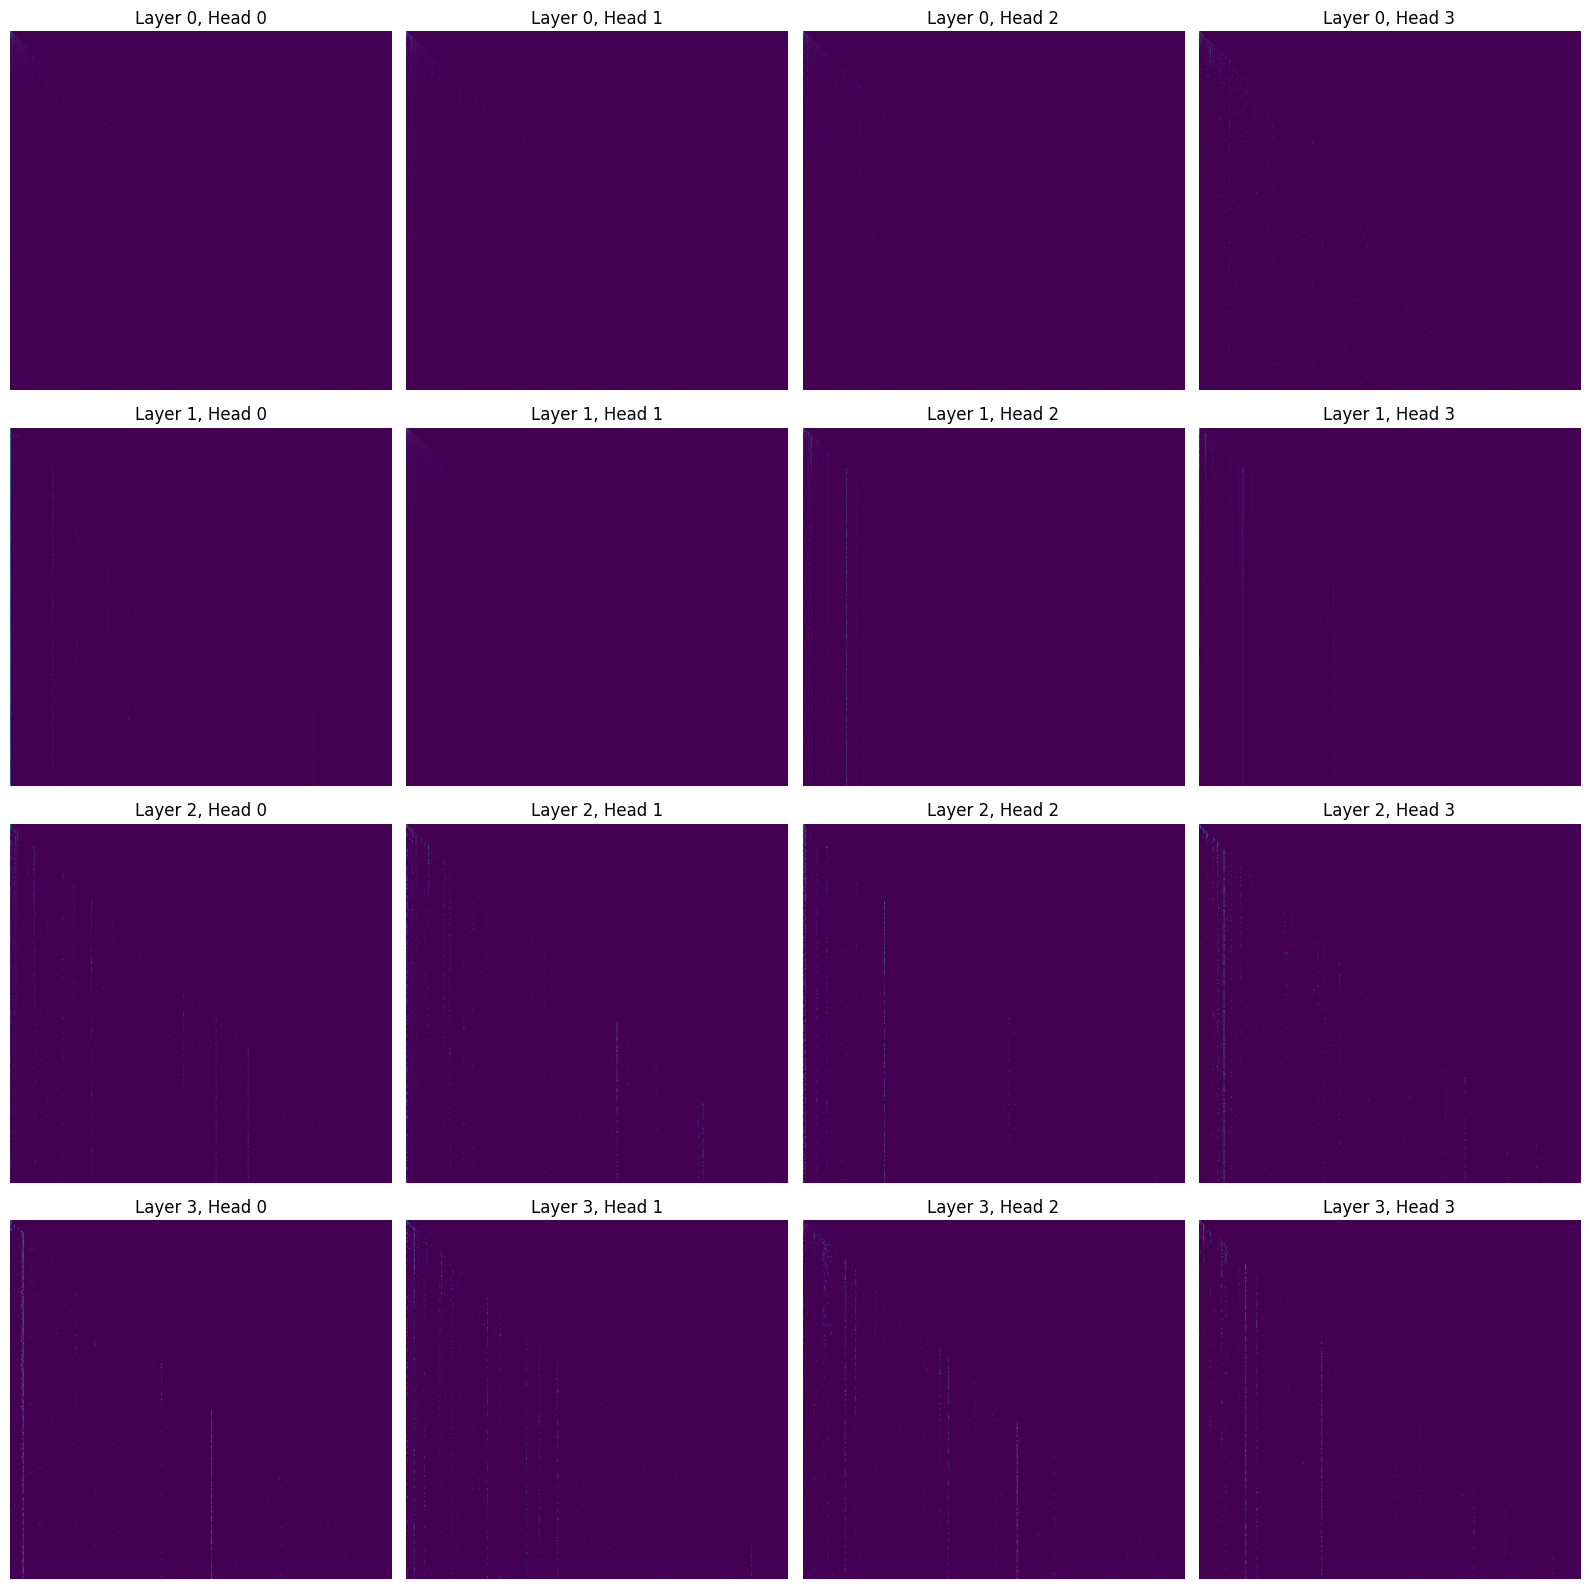



Attention patterns for line character 'i':
Sample 4: cecxcupk Nkerr syghyxn. Dmdmfjwifw.


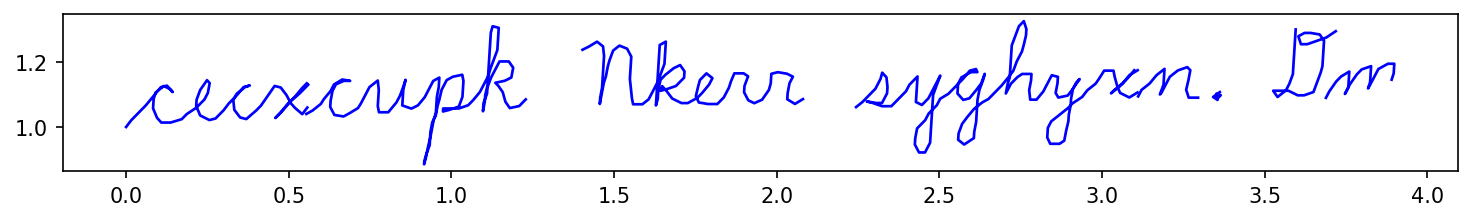

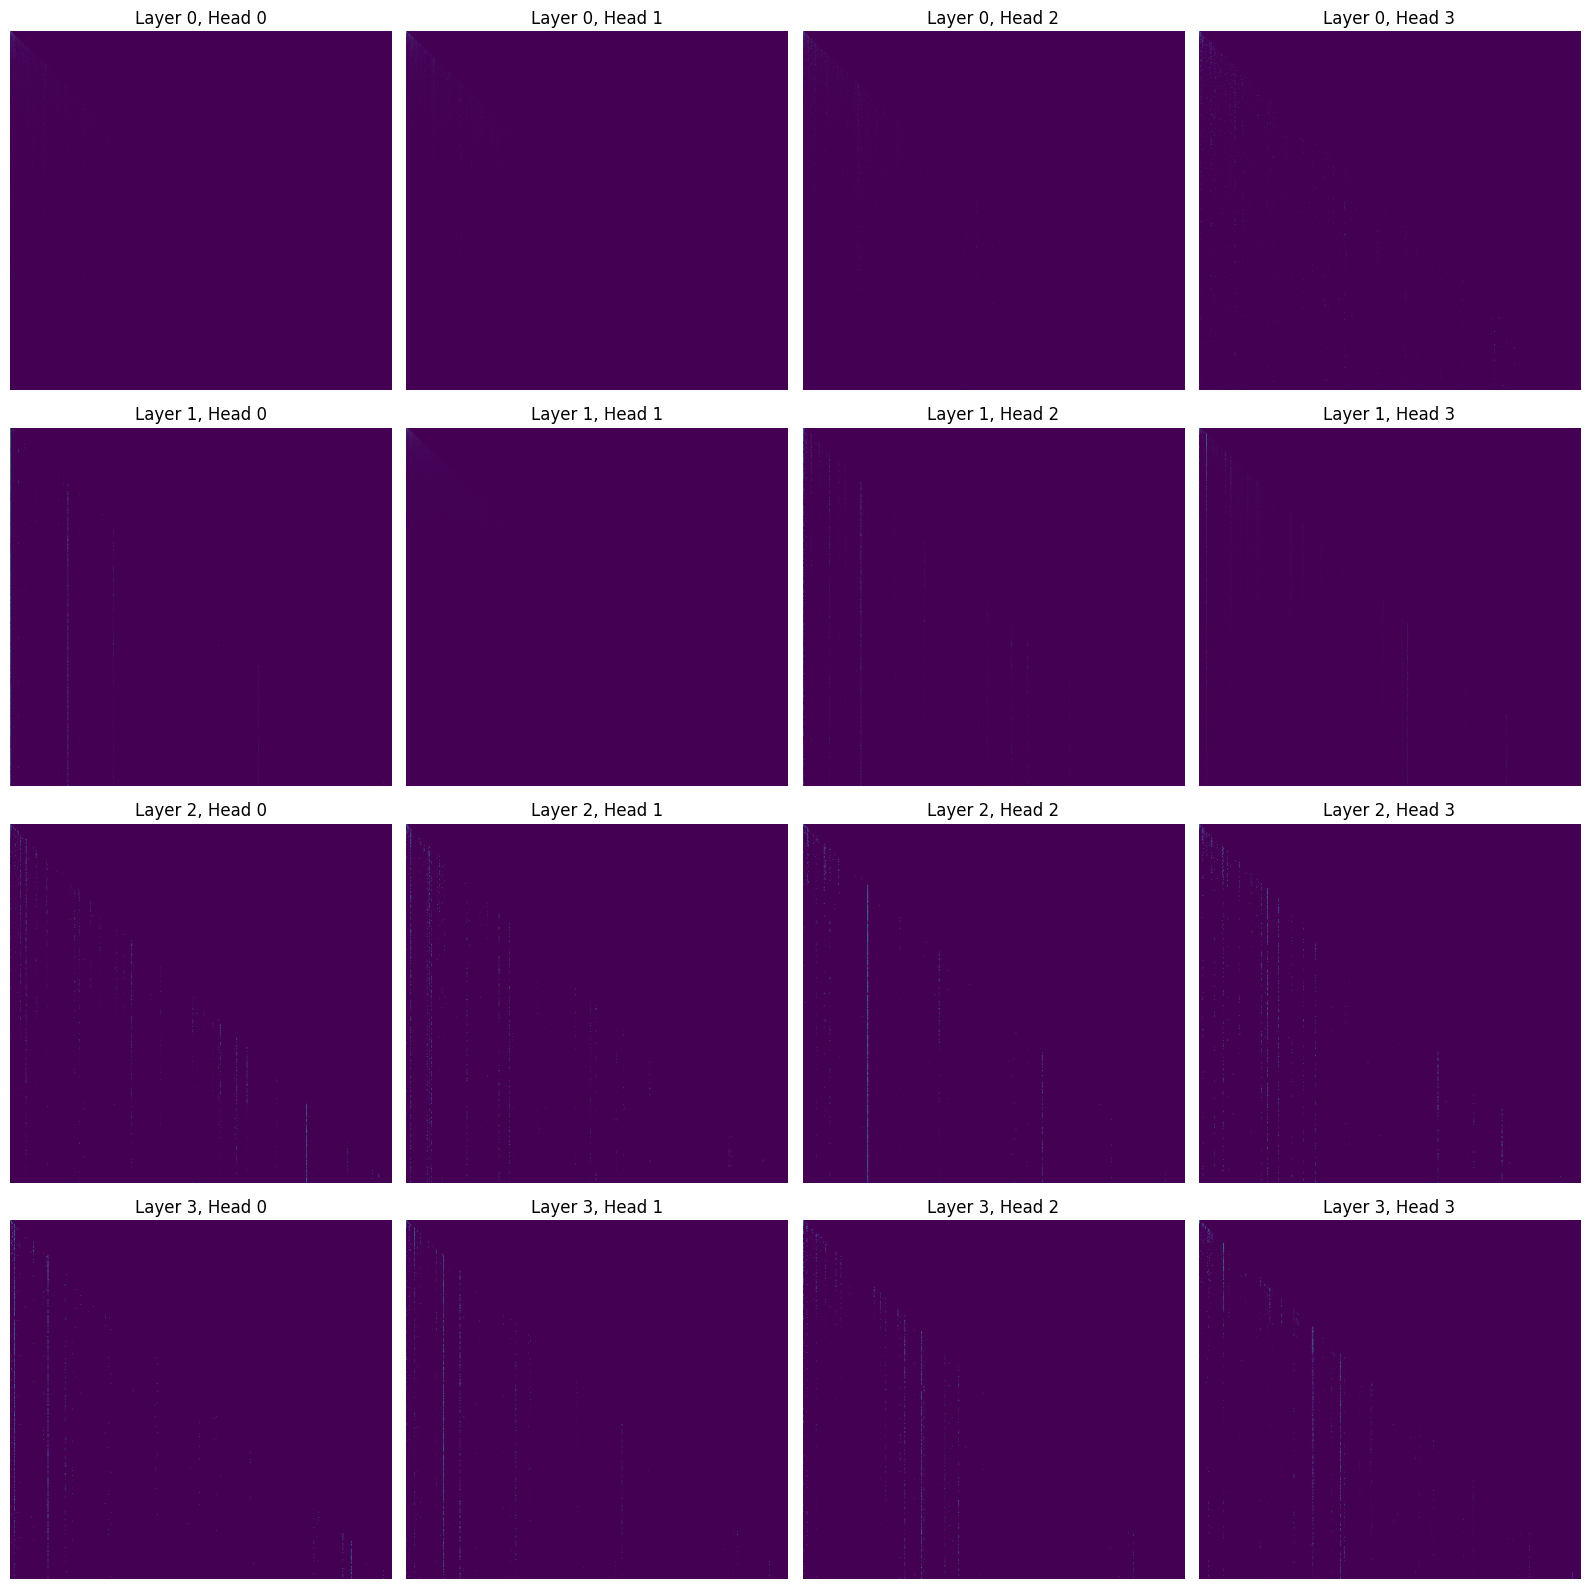



Sample 14: 8.0' Zaagzeb) UHAFVH airi


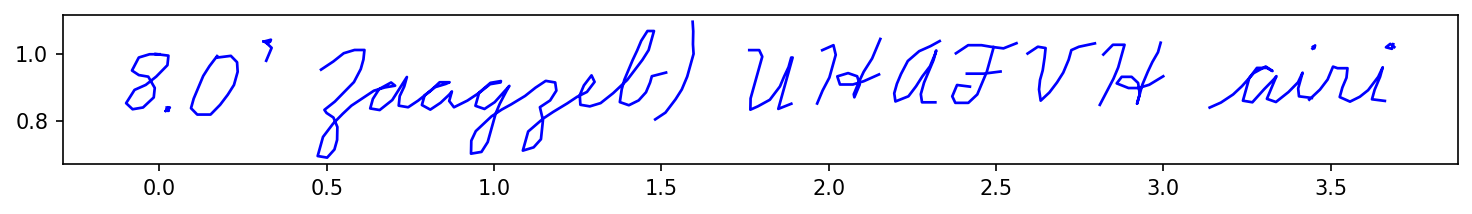

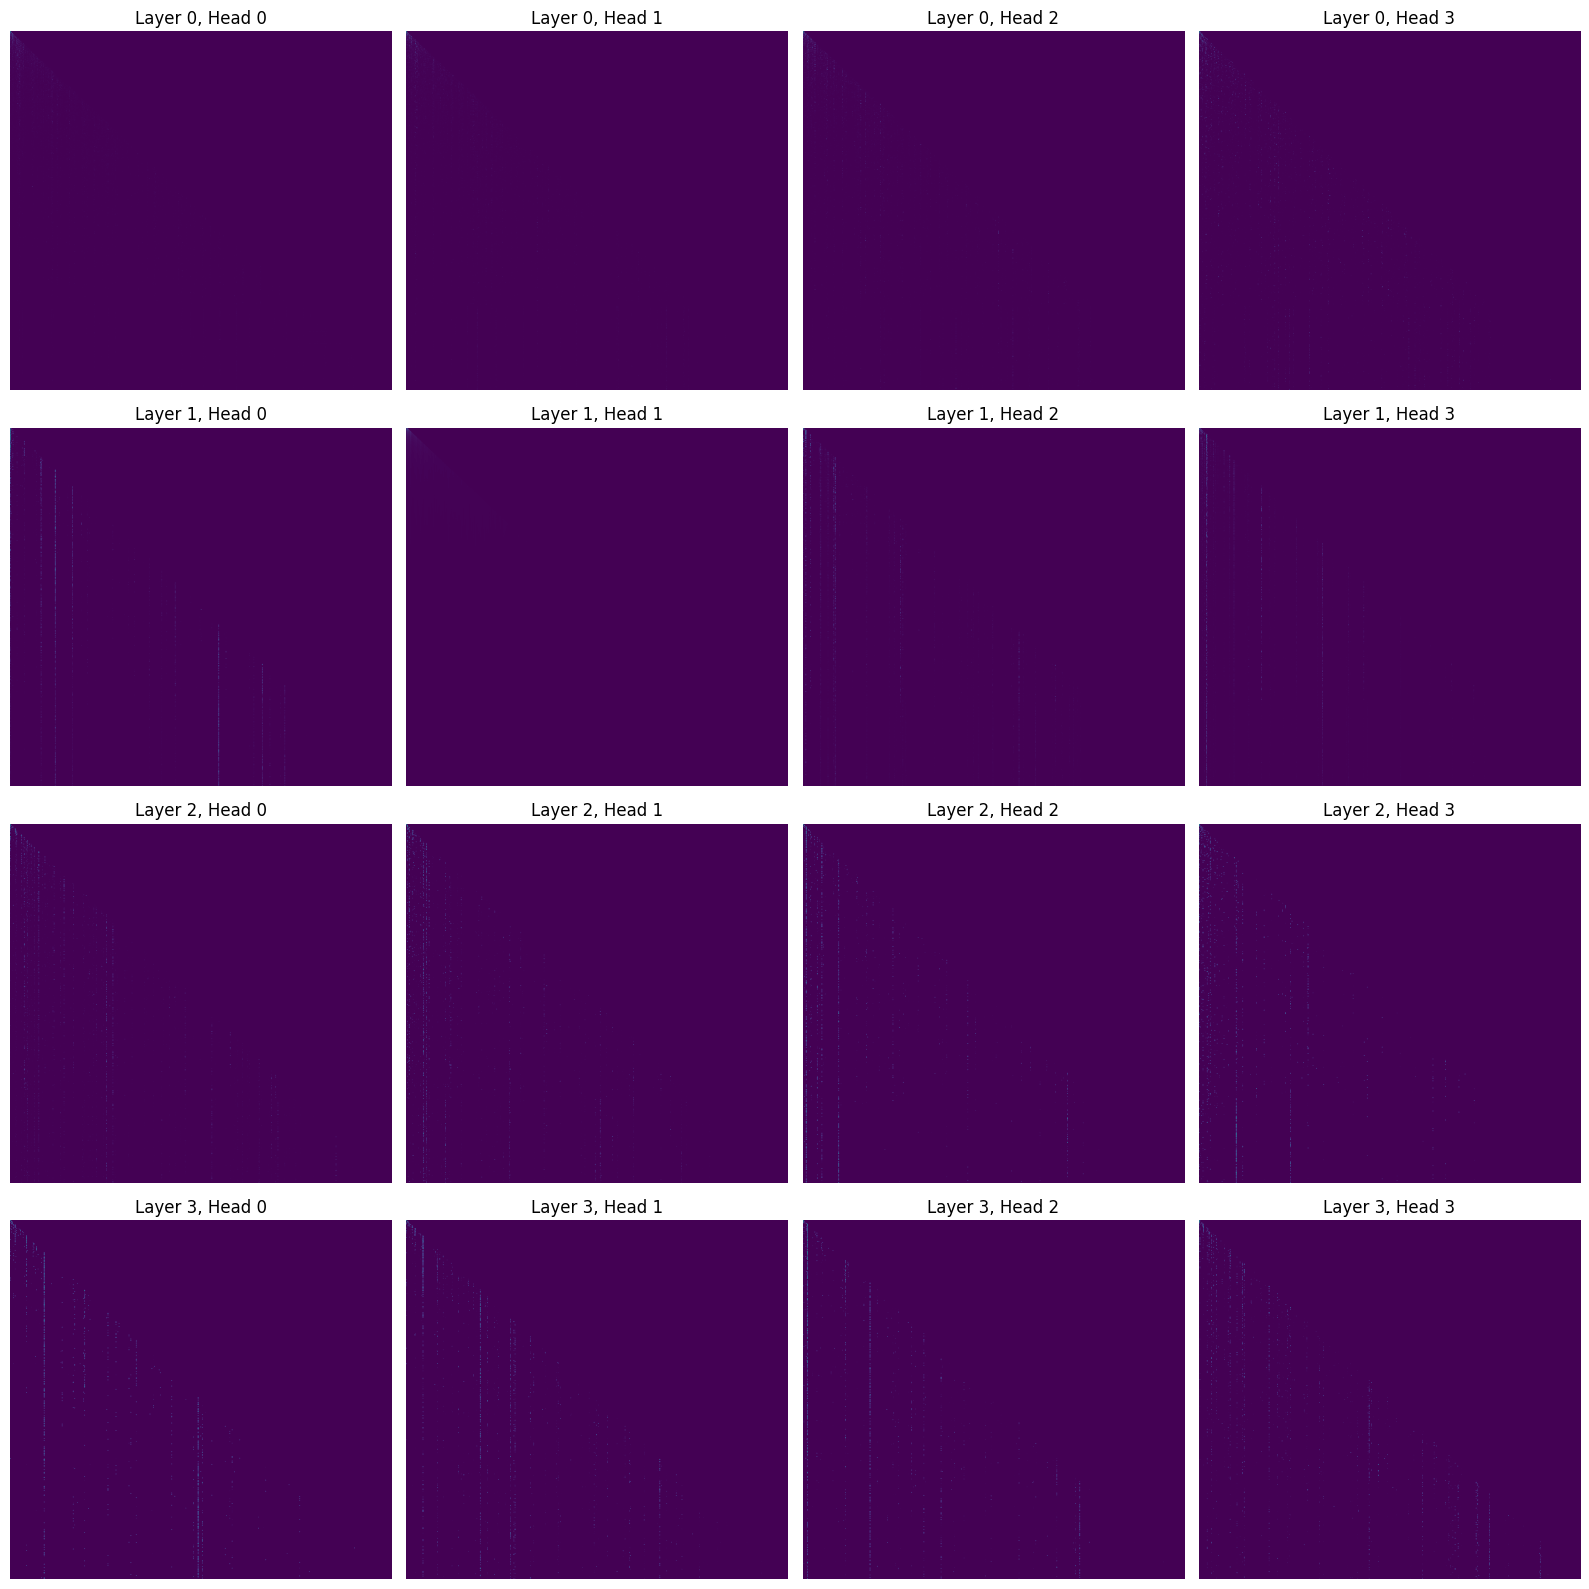



Sample 17: "aiknb tyfsuh 6.0 Nkerr


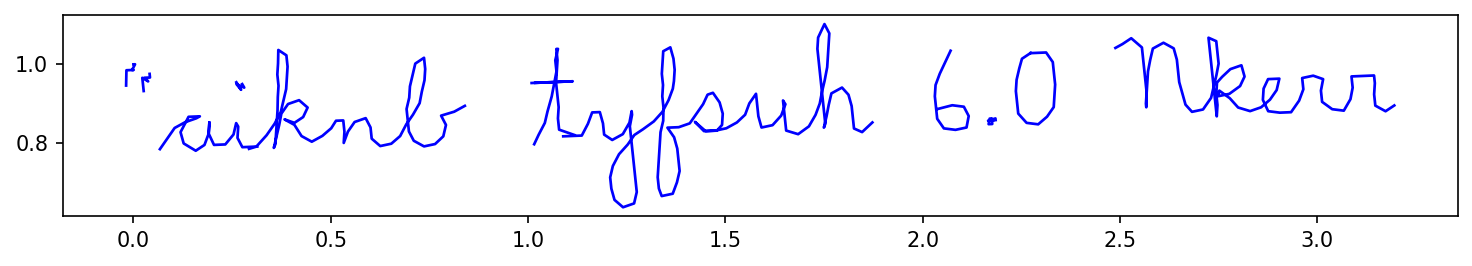

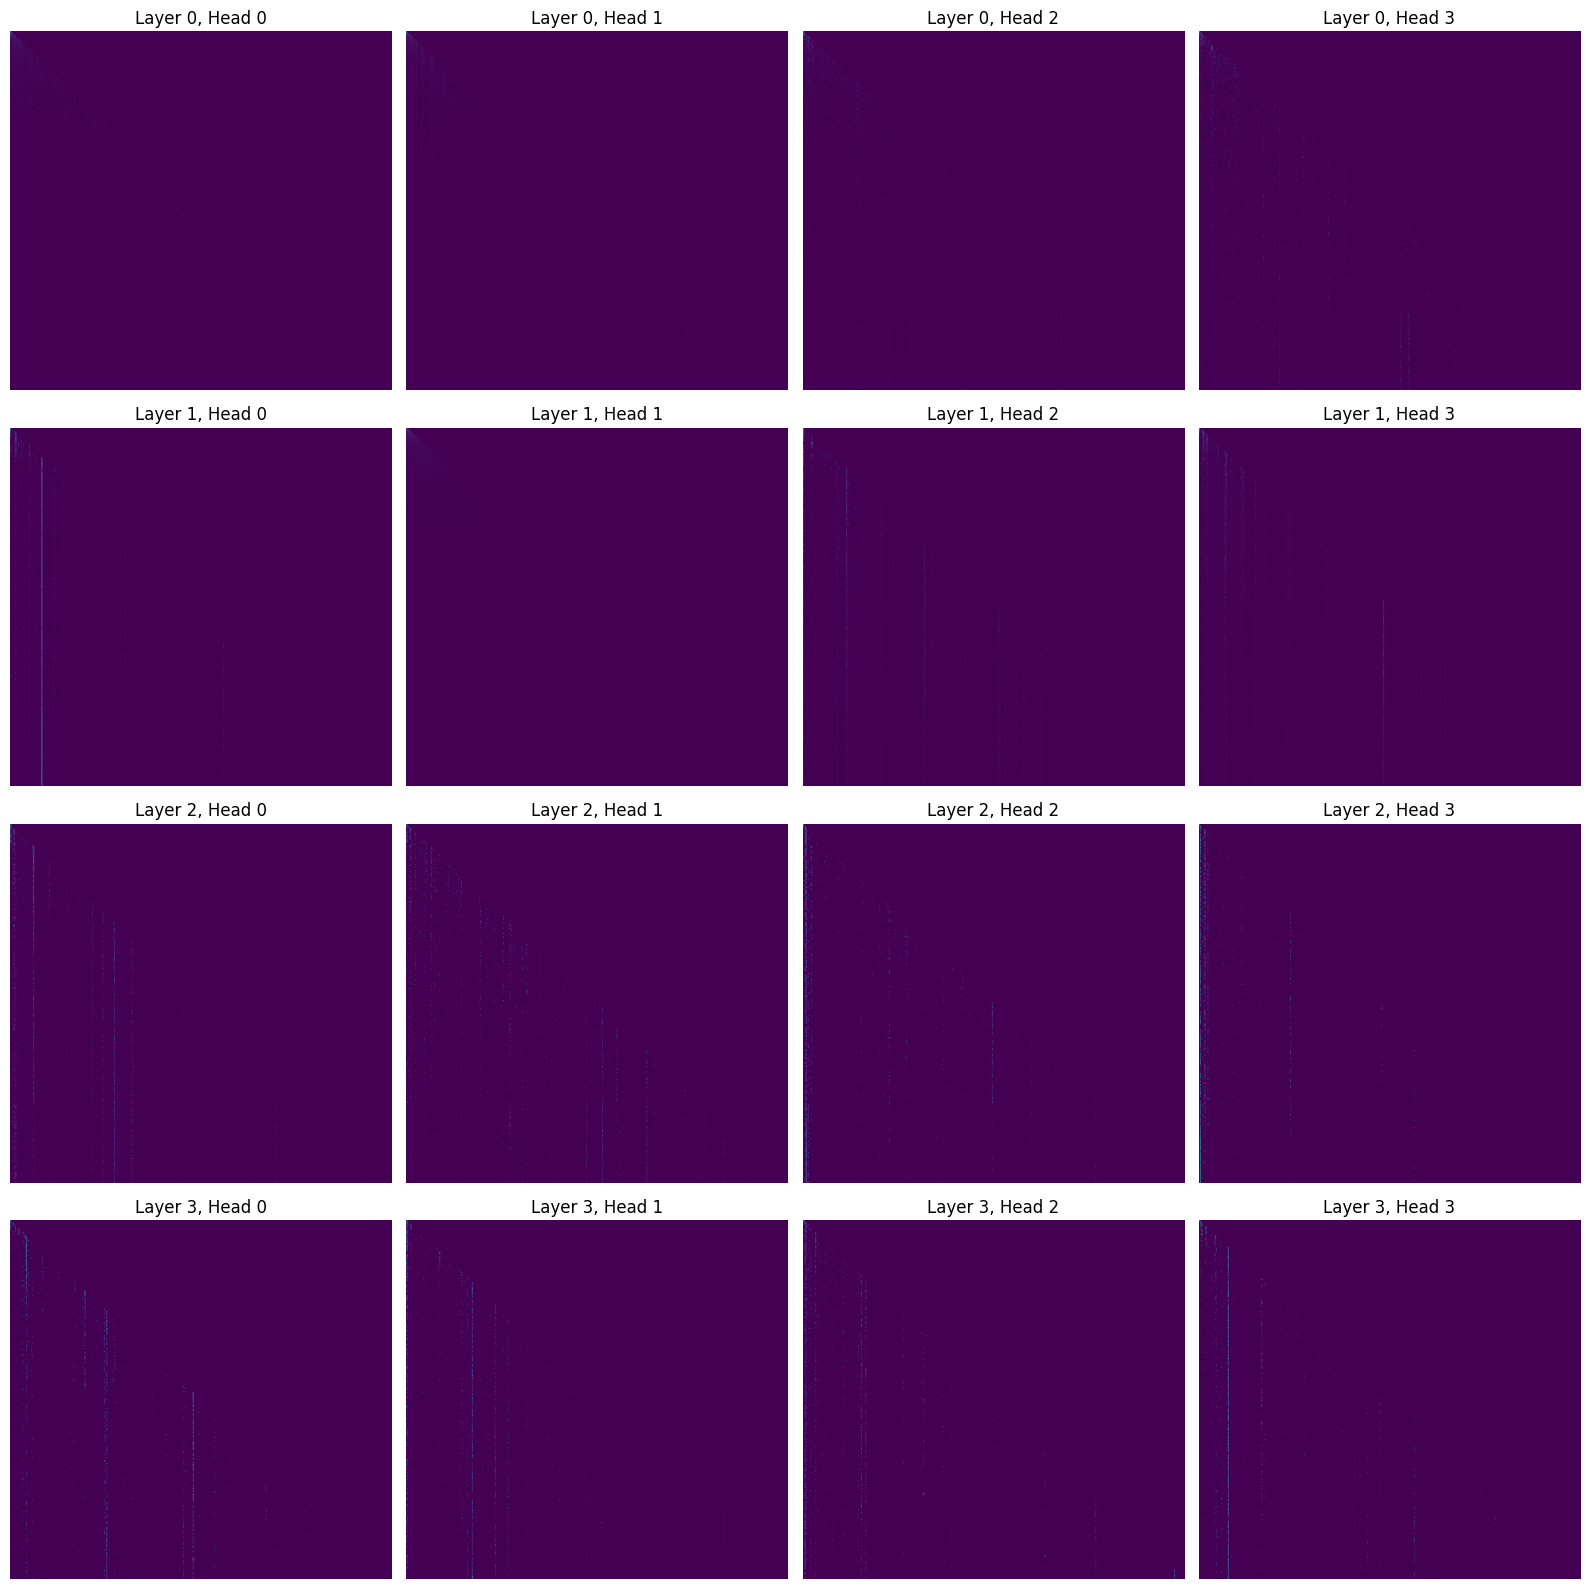

In [10]:
def find_samples_with_char(dataset, char, num_samples=3):
    samples = []
    for i in range(len(dataset)):
        x, c, y = dataset[i]
        text = dataset.decode_text(c)
        if char in text:
            samples.append((i, text, x, c, y))
            if len(samples) == num_samples:
                break
    return samples

def visualize_char_samples(dataset, char, num_samples=3):
    samples = find_samples_with_char(dataset, char, num_samples)
    for idx, text, x, c, y in samples:
        print(f"Sample {idx}: {text}")
        strokes = offsets_to_strokes(dataset.decode_stroke(x))
        _ = plot_strokes(strokes, "")
        _ = visualize_attention(model, x.unsqueeze(0), c.unsqueeze(0), layer_range=range(4), head_range=range(4), attn_type='self')
        print("\n")

print("Attention patterns for loop character 'o':")
visualize_char_samples(test_dataset, 'o')

print("Attention patterns for line character 'i':")
visualize_char_samples(test_dataset, 'i')

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

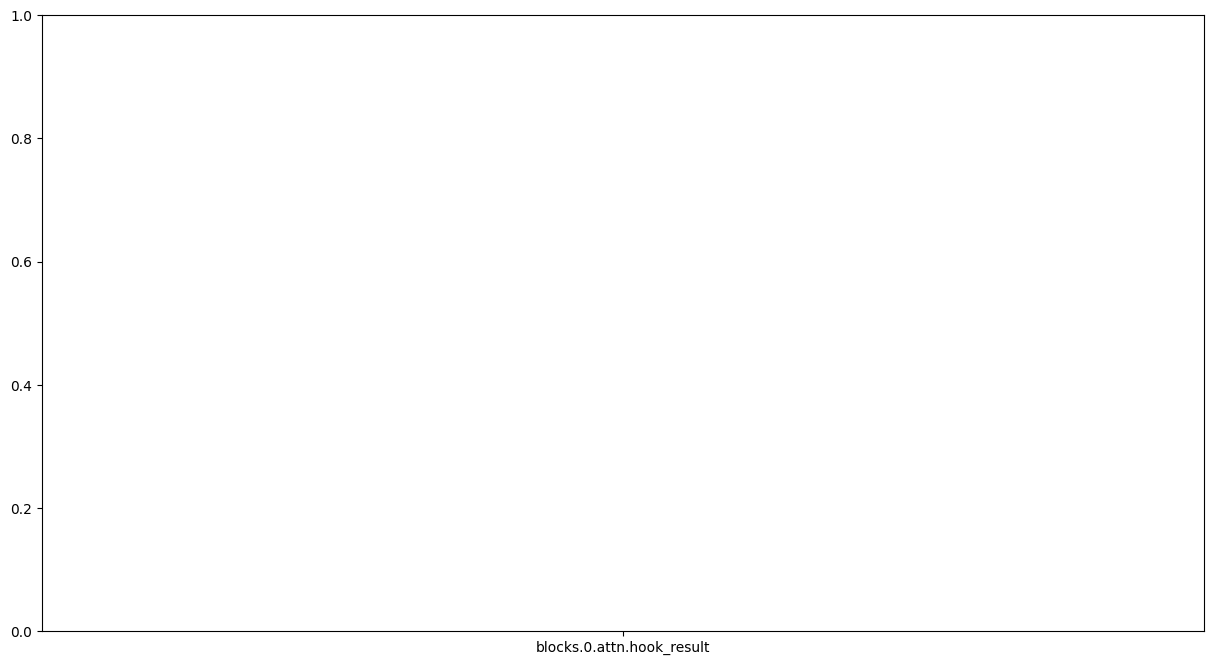

In [11]:
import torch
import matplotlib.pyplot as plt
from typing import List, Tuple

def find_samples_with_char(dataset, char: str, num_samples: int = 5) -> List[int]:
    samples = []
    for i in range(len(dataset)):
        _, c, _ = dataset[i]
        text = dataset.decode_text(c)
        if char in text:
            samples.append(i)
            if len(samples) == num_samples:
                break
    return samples

def create_clean_corrupted_pair(dataset, index: int, char_to_swap: str) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    x, c, _ = dataset[index]
    text = dataset.decode_text(c)

    # Find the position of the character to swap
    char_pos = text.index(char_to_swap)

    # Create corrupted text
    corrupted_text = text[:char_pos] + ('i' if char_to_swap == 'o' else 'o') + text[char_pos+1:]

    # Create corrupted character tokens
    c_corrupted = dataset.encode_text(corrupted_text)

    # Estimate the stroke tokens corresponding to the character
    # This is a rough estimate and might need refinement
    stroke_start = int(char_pos * (len(x) / len(text)))
    stroke_end = int((char_pos + 1) * (len(x) / len(text)))

    # Create corrupted stroke tokens
    x_corrupted = x.clone()
    x_corrupted[stroke_start:stroke_end] = torch.randint_like(x[stroke_start:stroke_end], 0, dataset.get_vocab_size())

    return x, c, x_corrupted, c_corrupted

def logits_to_logit_diff(logits, dataset, correct_answer: str = "o", incorrect_answer: str = "i"):
    correct_index = dataset.stoi.get(correct_answer, dataset.char_PAD_TOKEN)
    incorrect_index = dataset.stoi.get(incorrect_answer, dataset.char_PAD_TOKEN)
    return logits[0, -1, correct_index] - logits[0, -1, incorrect_index]

def activation_patching(
    model: HookedCursiveTransformer,
    dataset,
    clean_x: torch.Tensor,
    clean_c: torch.Tensor,
    corrupted_x: torch.Tensor,
    corrupted_c: torch.Tensor,
    patching_locations: List[str]
):
    # Run on clean input and cache activations
    clean_logits, clean_cache = model.run_with_cache(clean_x, clean_c)
    clean_logit_diff = logits_to_logit_diff(clean_logits, dataset)

    # Run on corrupted input without caching
    corrupted_logits = model(corrupted_x, corrupted_c)
    corrupted_logit_diff = logits_to_logit_diff(corrupted_logits, dataset)

    results = {}
    for location in patching_locations:
        def patching_hook(corrupted_act, hook):
            clean_act = clean_cache[location]
            return clean_act

        patched_logits = model.run_with_hooks(
            corrupted_x,
            corrupted_c,
            fwd_hooks=[(location, patching_hook)]
        )
        patched_logit_diff = logits_to_logit_diff(patched_logits, dataset)

        results[location] = (patched_logit_diff - corrupted_logit_diff) / (clean_logit_diff - corrupted_logit_diff)

    return results

# Main execution
o_samples = find_samples_with_char(test_dataset, 'o', num_samples=5)
i_samples = find_samples_with_char(test_dataset, 'i', num_samples=5)

patching_locations = [
    f"blocks.{l}.attn.hook_result"
    for l in range(model.cfg.n_layers)
] + [
    f"blocks.{l}.attn.hook_q"
    for l in range(model.cfg.n_layers)
] + [
    f"blocks.{l}.attn.hook_k"
    for l in range(model.cfg.n_layers)
] + [
    f"blocks.{l}.attn.hook_v"
    for l in range(model.cfg.n_layers)
]

all_results = []

for sample_index in o_samples + i_samples:
    char_to_swap = 'o' if sample_index in o_samples else 'i'
    x, c, x_corrupted, c_corrupted = create_clean_corrupted_pair(test_dataset, sample_index, char_to_swap)

    results = activation_patching(model, test_dataset, x.unsqueeze(0), c.unsqueeze(0),
                                  x_corrupted.unsqueeze(0), c_corrupted.unsqueeze(0),
                                  patching_locations)
    all_results.append(results)

# Average results across all samples
avg_results = {loc: sum(r[loc] for r in all_results) / len(all_results) for loc in patching_locations}

# Visualize results
plt.figure(figsize=(15, 8))
plt.bar(avg_results.keys(), avg_results.values())
plt.title("Average Activation Patching Results")
plt.xlabel("Patching Location")
plt.ylabel("Normalized Logit Difference")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Visualize clean and corrupted strokes
for sample_index in o_samples + i_samples:
    char_to_swap = 'o' if sample_index in o_samples else 'i'
    x, c, x_corrupted, c_corrupted = create_clean_corrupted_pair(test_dataset, sample_index, char_to_swap)

    print(f"Clean text: {test_dataset.decode_text(c)}")
    print(f"Corrupted text: {test_dataset.decode_text(c_corrupted)}")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plot_strokes(offsets_to_strokes(test_dataset.decode_stroke(x)), "Clean Stroke")
    plt.subplot(1, 2, 2)
    plot_strokes(offsets_to_strokes(test_dataset.decode_stroke(x_corrupted)), "Corrupted Stroke")
    plt.show()